<a href="https://colab.research.google.com/github/mdiamond42/gradient-short-circuit/blob/main/GSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import runtime
runtime.unassign()


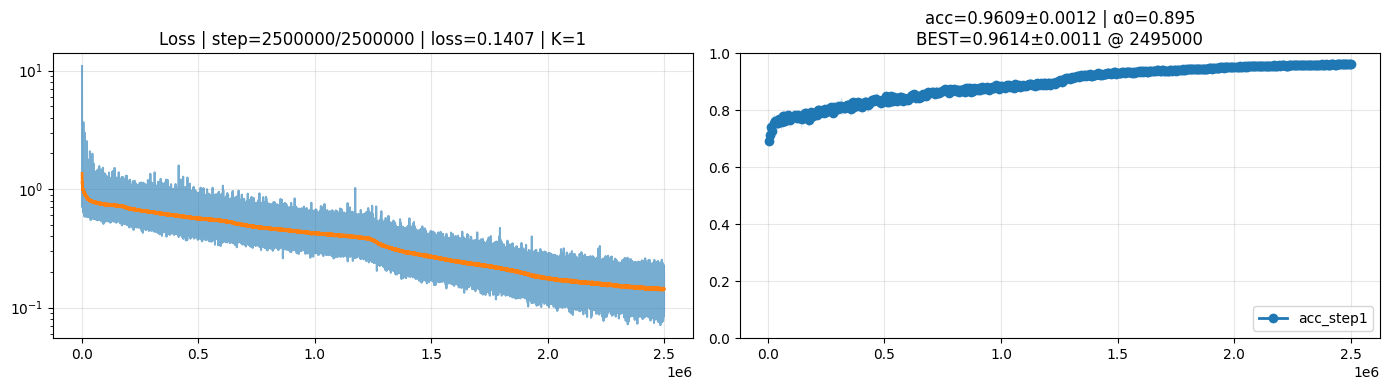

✅ step 2500000/2500000 | K=1
   acc=0.9609±0.0012 | metric=0.9603
   BEST: 0.9614±0.0011 @ 2495000

🎉 Training complete!
Final: /content/drive/My Drive/GradientShortCircuit_Experiments/GSC_37dim_96hidden_K1_g2proxy_200k.pth
Best:  /content/drive/My Drive/GradientShortCircuit_Experiments/GSC_37dim_96hidden_K1_g2proxy_200k_BEST.pth


In [ ]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from google.colab import drive

# ============================================================
# GSC with 96-HIDDEN STUDENT + FINE-GRAINED FEATURES (37-dim)
#
# Student: 784 → 96 → 10 (1.5x capacity vs 64-hidden baseline)
#
# Hessian: Simple g^2 proxy (faster than Hutchinson)
#
# New features for better resolution in low-loss regions:
#   1. Distance from current weight center (per-weight)
#   2. Center drift from initialization (scalar)
#   3. Raw gradient magnitude (log1p, unsquashed)
#   4. Curvature-to-gradient ratio (Hessian/grad)
#
# Hypothesis: Soft-squashed features lose fine detail when
# weights are near optimum. Raw/ratio features preserve the
# signal needed for precise refinement.
#
# Total features: 33 (baseline) + 4 (new) = 37
# K schedule: K=1 always (no K=2 switch)
# ============================================================

torch.set_grad_enabled(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Running on {device}")

drive.mount("/content/drive", force_remount=True)


# ============================================================
# Helpers
# ============================================================
def atomic_save(state, filepath):
    tmp = filepath + ".tmp"
    torch.save(state, tmp)
    os.replace(tmp, filepath)

def loss_stats(loss_history, window=500):
    if len(loss_history) == 0:
        return float("nan"), float("nan")
    last = float(loss_history[-1])
    w = int(min(window, len(loss_history)))
    avg = float(np.mean(loss_history[-w:]))
    return last, avg

@torch.no_grad()
def update_ema(ema_model, model, decay):
    for p_ema, p in zip(ema_model.parameters(), model.parameters()):
        p_ema.mul_(decay).add_(p, alpha=1 - decay)

def soft_squash(x, eps=1e-8):
    s = x.detach().abs().median().clamp(min=eps)
    return torch.tanh(x / (3.0 * s))

def signed_log1p(x):
    return torch.sign(x) * torch.log1p(x.abs())


# ============================================================
# Data
# ============================================================
class FastMNISTLoader:
    def __init__(self, device):
        print("📥 Pre-loading MNIST to GPU VRAM...")
        self.device = device
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_data = datasets.MNIST("./data", train=True, download=True, transform=transform)
        test_data  = datasets.MNIST("./data", train=False, download=True, transform=transform)

        self.train_x = train_data.data.view(-1, 784).float().to(device) / 255.0
        self.train_y = train_data.targets.to(device)
        self.test_x  = test_data.data.view(-1, 784).float().to(device) / 255.0
        self.test_y  = test_data.targets.to(device)

        self.train_x = (self.train_x - 0.1307) / 0.3081
        self.test_x  = (self.test_x  - 0.1307) / 0.3081

        self.num_train = self.train_x.shape[0]

    def sample_train(self, batch_size):
        idx = torch.randint(0, self.num_train, (batch_size,), device=self.device)
        return self.train_x[idx], self.train_y[idx]

    def get_full_test(self):
        return self.test_x, self.test_y


# ============================================================
# Student
# ============================================================
class MNISTStudent(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 96),  # Changed from 64 to 96
            nn.ReLU(),
            nn.Linear(96, 10)    # Changed from 64 to 96
        )

    def forward(self, x):
        return self.net(x)

    def functional_forward(self, x, params):
        x = F.linear(x, params[0], params[1])
        x = F.relu(x)
        x = F.linear(x, params[2], params[3])
        return x

def reset_student(net):
    for m in net.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)


# ============================================================
# Probe + curvature
# ============================================================
def _rademacher_like(t: torch.Tensor) -> torch.Tensor:
    return (torch.randint(0, 2, t.shape, device=t.device, dtype=torch.int8) * 2 - 1).to(dtype=t.dtype)

def compute_probe_and_curv_fullcombo(
    student, params, x_support, y_support,
    probe_lr=0.02, jerk_scale=1e-4,
    hutchinson_samples=3
):
    p0 = [p.detach().clone().requires_grad_(True) for p in params]

    logits1 = student.functional_forward(x_support, p0)
    loss1 = F.cross_entropy(logits1, y_support)

    grads1 = torch.autograd.grad(loss1, p0, create_graph=False)
    g1 = [g.detach() for g in grads1]

    # Simple Hessian proxy: g^2 (much faster than Hutchinson)
    h_diag = [g.pow(2) for g in g1]

    # Probe step 1
    p1 = [(pp - probe_lr * gg).detach().requires_grad_(True) for pp, gg in zip(p0, g1)]
    logits2 = student.functional_forward(x_support, p1)
    loss2 = F.cross_entropy(logits2, y_support)
    deltaL1 = float((loss2 - loss1).detach().item())
    grads2 = torch.autograd.grad(loss2, p1, create_graph=False)
    g2 = [g.detach() for g in grads2]
    accel = [g2i - g1i for g1i, g2i in zip(g1, g2)]

    # cos(g1,g2)
    eps = 1e-12
    dot = torch.zeros((), device=g1[0].device)
    n1  = torch.zeros((), device=g1[0].device)
    n2  = torch.zeros((), device=g1[0].device)
    for a, b in zip(g1, g2):
        aa = a.reshape(-1)
        bb = b.reshape(-1)
        dot = dot + (aa * bb).sum()
        n1  = n1  + (aa * aa).sum()
        n2  = n2  + (bb * bb).sum()
    cosv = float((dot / (torch.sqrt(n1).clamp_min(eps) * torch.sqrt(n2).clamp_min(eps))).detach().item())

    # Probe step 2
    p2 = [(pp - probe_lr * gg).detach().requires_grad_(True) for pp, gg in zip(p1, g2)]
    logits3 = student.functional_forward(x_support, p2)
    loss3 = F.cross_entropy(logits3, y_support)
    deltaL2_raw = float((loss3 - loss2).detach().item())
    grads3 = torch.autograd.grad(loss3, p2, create_graph=False)
    g3 = [g.detach() for g in grads3]

    jerk = [float(jerk_scale) * (g3i - 2.0*g2i + g1i) for g1i, g2i, g3i in zip(g1, g2, g3)]
    return g1, accel, jerk, h_diag, deltaL1, deltaL2_raw, cosv


# ============================================================
# Hypertuner (37-dim with fine-grained features)
# ============================================================
class FineGrainedHypertuner37(nn.Module):
    def __init__(self, num_layers=2, deltal_scale=2.0, deltal2_scale=5.0, alpha_head_max=0.5):
        super().__init__()
        self.layer_embeddings = nn.Embedding(num_layers, 10)

        self.predictor = nn.Sequential(
            nn.Linear(37, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.alpha_head = nn.Sequential(
            nn.Linear(37, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
        with torch.no_grad():
            self.alpha_head[-1].bias.fill_(0.0)

        self.deltal_scale = float(deltal_scale)
        self.deltal2_scale = float(deltal2_scale)
        self.alpha_head_max = float(alpha_head_max)

    def forward(self, weight, grad_g1, grad_accel, grad_jerk, h_diag, layer_idx,
                support_ce_scalar, deltaL1_scalar, deltaL2_scalar, cos_scalar):
        batch_size = weight.numel()
        w_flat = weight.reshape(-1, 1)

        # Existing squashed features
        g_flat = soft_squash(grad_g1).reshape(-1, 1)
        a_flat = soft_squash(grad_accel).reshape(-1, 1)
        j_flat = soft_squash(grad_jerk).reshape(-1, 1)
        h_feat = soft_squash(signed_log1p(h_diag)).reshape(-1, 1)

        dL1_feat = torch.tanh(torch.full((batch_size, 1), float(deltaL1_scalar) * self.deltal_scale,
                                         device=weight.device, dtype=w_flat.dtype))
        dL2_feat = torch.tanh(torch.full((batch_size, 1), float(deltaL2_scalar) * self.deltal2_scale,
                                         device=weight.device, dtype=w_flat.dtype))

        cos_feat = torch.full((batch_size, 1), float(cos_scalar), device=weight.device, dtype=w_flat.dtype)
        ce_feat  = torch.full((batch_size, 1), float(support_ce_scalar), device=weight.device, dtype=w_flat.dtype)

        # Magnitude features (log1p of median)
        log_mag_g1    = float(torch.log1p(grad_g1.detach().abs().median()).item())
        log_mag_accel = float(torch.log1p(grad_accel.detach().abs().median()).item())
        log_mag_jerk  = float(torch.log1p(grad_jerk.detach().abs().median()).item())
        log_mag_h     = float(torch.log1p(h_diag.detach().abs().median()).item())
        mag_features = torch.tensor([log_mag_g1, log_mag_accel, log_mag_jerk, log_mag_h],
                                    device=weight.device, dtype=w_flat.dtype).unsqueeze(0).expand(batch_size, -1)

        # === NEW FINE-GRAINED FEATURES ===

        # 1. Current center of weight distribution
        current_center = float(weight.mean().item())

        # 2. Distance from current center (per-weight, preserves fine detail)
        dist_current_center = torch.log1p((w_flat - current_center).abs())

        # 3. Center drift from initialization (how much distribution shifted)
        center_drift = torch.log1p(torch.abs(torch.tensor(current_center, device=weight.device)))
        center_drift_feat = torch.full((batch_size, 1), float(center_drift.item()),
                                      device=weight.device, dtype=w_flat.dtype)

        # 4. Raw gradient magnitude (unsquashed, preserves scale in low-loss regions)
        grad_mag_raw = torch.log1p(grad_g1.abs()).reshape(-1, 1)

        # 5. Curvature-to-gradient ratio (indicates proximity to minimum)
        # High ratio = small gradients, high curvature = near minimum
        # Low ratio = large gradients, low curvature = far from minimum
        h_to_g_ratio = soft_squash(h_diag.abs() / (grad_g1.abs() + 1e-8)).reshape(-1, 1)

        # Geometry features (same as before)
        if weight.dim() > 1:
            rows, cols = weight.shape
            val_in, val_out = float(np.log1p(cols)), float(np.log1p(rows))

            r_idx = torch.arange(rows, device=weight.device)
            c_idx = torch.arange(cols, device=weight.device)
            r = r_idx.repeat_interleave(cols).float().reshape(-1, 1) / rows
            c = c_idx.repeat(rows).float().reshape(-1, 1) / cols

            center_row = (rows - 1) / 2.0
            center_col = (cols - 1) / 2.0
            rr = r_idx.repeat_interleave(cols).float()
            cc = c_idx.repeat(rows).float()
            dist = torch.sqrt((rr - center_row) ** 2 + (cc - center_col) ** 2)
            max_dist = torch.sqrt(torch.tensor(center_row**2 + center_col**2, device=weight.device, dtype=dist.dtype)).clamp(min=1e-8)
            dist_center = (dist / max_dist).reshape(-1, 1)

            fan_in = max(int(cols), 1)
            sigma = torch.sqrt(torch.tensor(2.0 / fan_in, device=weight.device, dtype=w_flat.dtype)).clamp(min=1e-8)
            dist_origin = torch.log1p(w_flat.abs() / sigma)

            row_norms = grad_g1.norm(dim=1, keepdim=True)
            col_norms = grad_g1.norm(dim=0, keepdim=True).t()
            row_feat = soft_squash(row_norms.repeat_interleave(cols, dim=0))
            col_feat = soft_squash(col_norms.repeat(rows, 1))

            g_mean = g_flat.mean().expand(batch_size, 1)
            g_std  = g_flat.std().expand(batch_size, 1)

            t_in  = torch.full((batch_size, 1), val_in, device=weight.device)
            t_out = torch.full((batch_size, 1), val_out, device=weight.device)

        else:
            rows = weight.shape[0]
            r_idx = torch.arange(rows, device=weight.device)
            r = r_idx.float().reshape(-1, 1) / rows
            c = torch.zeros_like(r)

            center = (rows - 1) / 2.0
            dist = (r_idx.float() - center).abs()
            max_dist = torch.tensor(center, device=weight.device, dtype=dist.dtype).clamp(min=1e-8)
            dist_center = (dist / max_dist).reshape(-1, 1)

            fan_in = 784 if layer_idx == 0 else 96  # Changed from 64 to 96
            sigma = torch.sqrt(torch.tensor(2.0 / fan_in, device=weight.device, dtype=w_flat.dtype)).clamp(min=1e-8)
            dist_origin = torch.log1p(w_flat.abs() / sigma)

            row_feat = soft_squash(grad_g1.abs().reshape(-1, 1))
            col_feat = torch.zeros_like(row_feat)

            g_mean = g_flat.mean().expand(batch_size, 1)
            g_std  = g_flat.std().expand(batch_size, 1)

            t_in  = torch.zeros((batch_size, 1), device=weight.device)
            t_out = torch.full((batch_size, 1), float(np.log1p(rows)), device=weight.device)

        l_emb = self.layer_embeddings(torch.tensor([layer_idx], device=weight.device)).expand(batch_size, -1)

        # Concatenate all 37 features
        inputs = torch.cat([
            w_flat,                    # 1
            g_flat,                    # 1
            a_flat,                    # 1
            j_flat,                    # 1
            l_emb,                     # 10
            g_mean, g_std,             # 2
            t_in, t_out,               # 2
            r, c,                      # 2
            dist_center,               # 1
            dist_origin,               # 1
            row_feat, col_feat,        # 2
            h_feat,                    # 1
            dL1_feat, dL2_feat,        # 2
            cos_feat, ce_feat,         # 2
            mag_features,              # 4
            # === NEW (4) ===
            dist_current_center,       # 1 - distance from moving center
            center_drift_feat,         # 1 - how much center drifted
            grad_mag_raw,              # 1 - raw gradient magnitude
            h_to_g_ratio,              # 1 - curvature/gradient ratio
        ], dim=1)  # Total: 37

        delta = 0.5 * torch.tanh(self.predictor(inputs))
        p_full = (w_flat + delta).view_as(weight)

        a0 = self.alpha_head_max * torch.sigmoid(self.alpha_head(inputs))
        return p_full, a0.view_as(weight)


# ============================================================
# Eval
# ============================================================
def eval_step1_multitrial(ht, fast_loader, student, cfg, trials=10):
    ht.eval()
    x_test, y_test = fast_loader.get_full_test()

    accs = []
    a0_means = []

    for _ in range(trials):
        reset_student(student)
        student.eval()
        params0 = [p.detach().clone() for p in student.parameters()]
        x_s, y_s = fast_loader.sample_train(cfg["BATCH"])

        jscale = cfg["JERK_EVAL_SCALE"]

        with torch.enable_grad():
            g1, accel, jerk, h0, dL1, dL2, cosv = compute_probe_and_curv_fullcombo(
                student, params0, x_s, y_s,
                probe_lr=cfg["PROBE_LR"],
                jerk_scale=jscale,
                hutchinson_samples=cfg["HUTCHINSON_SAMPLES"]
            )

        ce0 = float(F.cross_entropy(student.functional_forward(x_s, params0), y_s).item())

        with torch.no_grad():
            step1_full, alpha0 = [], []
            for i, (p, g1i, ai, ji, hi) in enumerate(zip(params0, g1, accel, jerk, h0)):
                pf, a = ht(p, g1i, ai, ji, hi, i // 2, ce0, dL1, dL2, cosv)
                step1_full.append(pf)
                alpha0.append(a)

            step1 = []
            a_used = []
            for i, (p, pf, a) in enumerate(zip(params0, step1_full, alpha0)):
                au = torch.clamp(a * cfg["MULTS"][i], 0.0, cfg["ALPHA_APPLY_MAX"])
                step1.append(p + au * (pf - p))
                a_used.append(float(au.mean().item()))

            acc = (student.functional_forward(x_test, step1).argmax(1) == y_test).float().mean().item()

        accs.append(acc)
        a0_means.append(float(np.mean(a_used)))

    return float(np.mean(accs)), float(np.std(accs)), float(np.mean(a0_means))


# ============================================================
# Train
# ============================================================
def train_fine_grained(cfg):
    experiment_dir = cfg["EXPERIMENT_DIR"]
    os.makedirs(experiment_dir, exist_ok=True)

    RUN_TAG = cfg["RUN_TAG"]
    CKPT_FILE = os.path.join(experiment_dir, f"{RUN_TAG}.pth")
    BEST_FILE = os.path.join(experiment_dir, f"{RUN_TAG}_BEST.pth")

    print("\n" + "="*120)
    print("🔬 96-HIDDEN STUDENT + FINE-GRAINED FEATURES (37-dim)")
    print(f"RUN_TAG: {RUN_TAG}")
    print(f"Target steps: {cfg['TARGET_STEPS']}")
    print("-"*120)
    print("Student: 784 → 96 → 10 (76,330 params, 1.5x vs 64-hidden baseline)")
    print("Hessian: g^2 proxy (faster than Hutchinson)")
    print("New features for low-loss resolution:")
    print("  1. Distance from current weight center (per-weight)")
    print("  2. Center drift from initialization (scalar)")
    print("  3. Raw gradient magnitude (unsquashed)")
    print("  4. Curvature-to-gradient ratio (H/g)")
    print("K schedule: K=1 always")
    print("="*120 + "\n")

    fast_loader = FastMNISTLoader(device)
    student = MNISTStudent().to(device)

    ht = FineGrainedHypertuner37(
        num_layers=2,
        deltal_scale=cfg["DELTAL_SCALE"],
        deltal2_scale=cfg["DELTAL2_SCALE"],
        alpha_head_max=cfg["ALPHA_HEAD_MAX"],
    ).to(device)

    optimizer = torch.optim.Adam(ht.parameters(), lr=cfg["LR"])

    ht_ema = None
    if cfg["USE_EMA"]:
        ht_ema = FineGrainedHypertuner37(
            num_layers=2,
            deltal_scale=cfg["DELTAL_SCALE"],
            deltal2_scale=cfg["DELTAL2_SCALE"],
            alpha_head_max=cfg["ALPHA_HEAD_MAX"],
        ).to(device)
        ht_ema.load_state_dict(ht.state_dict())

    start_step = 0
    loss_history = []
    acc_history = []
    best_acc_mean = 0.0
    best_acc_std = 0.0
    best_step = 0
    best_metric = -1e9

    # Resume if exists
    if os.path.exists(CKPT_FILE):
        print(f"📂 Resuming from: {CKPT_FILE}")
        ckpt = torch.load(CKPT_FILE, map_location=device)
        ht.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        if cfg["USE_EMA"] and "ema_state" in ckpt:
            ht_ema.load_state_dict(ckpt["ema_state"])
        start_step = ckpt["step"]
        loss_history = ckpt.get("loss_history", [])
        acc_history = ckpt.get("acc_history", [])
        best_acc_mean = ckpt.get("best_acc_mean", 0.0)
        best_acc_std = ckpt.get("best_acc_std", 0.0)
        best_step = ckpt.get("best_step", 0)
        best_metric = ckpt.get("best_metric", best_acc_mean)
        print(f"✅ Resumed at step {start_step}\n")

    ht.train()
    if cfg["USE_EMA"]:
        ht_ema.train()

    def jerk_scale_at(step):
        if step <= 0:
            return 1.0
        val = float(np.exp(-cfg["JERK_DECAY_RATE"] * float(step)))
        return max(cfg["MIN_JERK_SCALE"], val)

    def k_at(step):
        """K=1 always (pure K=1 experiment)"""
        return 1

    current_step = start_step

    while current_step < cfg["TARGET_STEPS"]:
        burst_end = min(current_step + cfg["BURST"], cfg["TARGET_STEPS"])
        t0 = time.time()

        for step_idx in range(current_step, burst_end):
            jscale = jerk_scale_at(step_idx)
            K = k_at(step_idx)

            optimizer.zero_grad(set_to_none=True)

            for _ in range(K):
                x_s, y_s = fast_loader.sample_train(cfg["BATCH"])
                x_q, y_q = fast_loader.sample_train(cfg["BATCH"])

                reset_student(student)
                student.train()
                params0 = [p.detach().clone() for p in student.parameters()]

                with torch.no_grad():
                    ce0 = float(F.cross_entropy(student.functional_forward(x_s, params0), y_s).item())

                with torch.enable_grad():
                    g1, accel, jerk, h0, dL1, dL2, cosv = compute_probe_and_curv_fullcombo(
                        student, params0, x_s, y_s,
                        probe_lr=cfg["PROBE_LR"],
                        jerk_scale=jscale,
                        hutchinson_samples=cfg["HUTCHINSON_SAMPLES"]
                    )

                step1_full, alpha0 = [], []
                for i, (p, g1i, ai, ji, hi) in enumerate(zip(params0, g1, accel, jerk, h0)):
                    pf, a = ht(p, g1i, ai, ji, hi, i // 2, ce0, dL1, dL2, cosv)
                    step1_full.append(pf)
                    alpha0.append(a)

                step1 = []
                for i, (p, pf, a) in enumerate(zip(params0, step1_full, alpha0)):
                    mult = cfg["MULTS"][i]
                    au = torch.clamp(a * mult, 0.0, cfg["ALPHA_APPLY_MAX"])
                    step1.append(p + au * (pf - p))

                ce1_q = F.cross_entropy(student.functional_forward(x_q, step1), y_q)
                (ce1_q / float(K)).backward()
                loss_history.append(float(ce1_q.item()))

            torch.nn.utils.clip_grad_norm_(ht.parameters(), max_norm=1.0)
            optimizer.step()

            if cfg["USE_EMA"]:
                update_ema(ht_ema, ht, cfg["EMA_DECAY"])

        current_step = burst_end

        # Save checkpoint
        ckpt_out = {
            "step": current_step,
            "model_state": ht.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "ema_state": ht_ema.state_dict() if cfg["USE_EMA"] else None,
            "loss_history": loss_history,
            "acc_history": acc_history,
            "best_acc_mean": best_acc_mean,
            "best_acc_std": best_acc_std,
            "best_step": best_step,
            "best_metric": best_metric,
            "config": cfg,
        }
        atomic_save(ckpt_out, CKPT_FILE)

        # Eval
        if (current_step % cfg["EVAL_EVERY"] == 0) or (current_step == cfg["TARGET_STEPS"]):
            loss_last, loss_ma500 = loss_stats(loss_history, window=500)

            eval_model = ht_ema if cfg["USE_EMA"] else ht
            acc_mean, acc_std, a0_mean = eval_step1_multitrial(eval_model, fast_loader, student, cfg, trials=cfg["EVAL_TRIALS"])
            metric = acc_mean - 0.5 * acc_std

            acc_history.append({
                "step": current_step,
                "acc_step1_mean": acc_mean,
                "acc_step1_std": acc_std,
                "alpha0_mean": a0_mean,
                "metric": metric,
                "k": k_at(max(0, current_step - 1)),
            })

            if metric > best_metric:
                best_metric = metric
                best_acc_mean = acc_mean
                best_acc_std = acc_std
                best_step = current_step

                best_state = {k: v.detach().cpu().clone() for k, v in eval_model.state_dict().items()}
                best_ckpt = {
                    "step": current_step,
                    "model_state": best_state,
                    "best_acc_mean": best_acc_mean,
                    "best_acc_std": best_acc_std,
                    "best_step": best_step,
                    "best_metric": best_metric,
                    "loss_history": loss_history,
                    "acc_history": acc_history,
                    "config": cfg,
                }
                atomic_save(best_ckpt, BEST_FILE)
                print(f"🏆 NEW BEST! step={best_step} acc={best_acc_mean:.4f}±{best_acc_std:.4f} metric={best_metric:.4f}")

            # Plot
            clear_output(wait=True)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

            ax1.plot(loss_history, alpha=0.6)
            if len(loss_history) > 500:
                ma = np.convolve(loss_history, np.ones(500)/500, mode="valid")
                ax1.plot(np.arange(499, len(loss_history)), ma, linewidth=2)

            ax1.set_title(f"Loss | step={current_step}/{cfg['TARGET_STEPS']} | loss={loss_last:.4f} | K={k_at(max(0, current_step-1))}")
            ax1.set_yscale("log")
            ax1.grid(True, alpha=0.3)

            xs = [h["step"] for h in acc_history]
            ys = [h["acc_step1_mean"] for h in acc_history]
            ss = [h["acc_step1_std"] for h in acc_history]
            ax2.plot(xs, ys, "o-", linewidth=2, label="acc_step1")
            ax2.fill_between(xs, np.array(ys)-np.array(ss), np.array(ys)+np.array(ss), alpha=0.2)

            ax2.set_ylim([0, 1])
            ax2.grid(True, alpha=0.3)
            ax2.legend(loc="lower right")

            last = acc_history[-1]
            ax2.set_title(
                f"acc={last['acc_step1_mean']:.4f}±{last['acc_step1_std']:.4f} | α0={last['alpha0_mean']:.3f}\n"
                f"BEST={best_acc_mean:.4f}±{best_acc_std:.4f} @ {best_step}"
            )

            plt.tight_layout()
            plt.show()

            print(f"✅ step {current_step}/{cfg['TARGET_STEPS']} | K={last.get('k', 1)}")
            print(f"   acc={last['acc_step1_mean']:.4f}±{last['acc_step1_std']:.4f} | metric={last['metric']:.4f}")
            print(f"   BEST: {best_acc_mean:.4f}±{best_acc_std:.4f} @ {best_step}")

        dt = time.time() - t0
        sps = cfg["BURST"] / max(dt, 1e-9)
        if current_step % cfg["EVAL_EVERY"] != 0:
            print(f"…step {current_step}/{cfg['TARGET_STEPS']} | K={k_at(max(0, current_step-1))} | {sps:.1f} steps/s")

    print("\n🎉 Training complete!")
    print(f"Final: {CKPT_FILE}")
    print(f"Best:  {BEST_FILE}")


# ============================================================
# CONFIG
# ============================================================
CFG = {
    "EXPERIMENT_DIR": "/content/drive/My Drive/GradientShortCircuit_Experiments",
    "RUN_TAG": "GSC_37dim_96hidden_K1_g2proxy_200k",

    "TARGET_STEPS": 2500_000,

    "BATCH": 1024,
    "PROBE_LR": 0.02,
    "BURST": 200,

    "JERK_DECAY_RATE": 0.0002,
    "MIN_JERK_SCALE": 1e-4,
    "JERK_EVAL_SCALE": 1e-4,

    "HUTCHINSON_SAMPLES": 3,

    "DELTAL_SCALE": 2.0,
    "DELTAL2_SCALE": 5.0,

    "ALPHA_HEAD_MAX": 0.5,
    "ALPHA_APPLY_MAX": 1.5,
    "MULTS": [1.8, 1.6, 2.0, 2.2],

    "USE_EMA": True,
    "EMA_DECAY": 0.9995,

    "LR": 5e-4,

    "EVAL_EVERY": 5000,
    "EVAL_TRIALS": 10,
}

# GO
train_fine_grained(CFG)

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from google.colab import drive

# ============================================================
# GSC EVAL SUITE — 96-HIDDEN + 37-DIM FEATURES
#
# Compatible with training run:
#   RUN_TAG = "GSC_37dim_96hidden_K1_g2proxy_200k"
#
# What it supports:
# - TEST A1: 10-trial one-shot   (Base vs Step1)
# - TEST A2: 10-trial two-step   (Base vs Step1 vs Step2, Δ(2-1))
# - TEST B : Serial refinement with gating + backtracking (support CE improves)
#
# Key details:
# - Student: 784 → 96 → 10
# - Hypertuner: 37-dim features (33 baseline + 4 fine-grained)
# - Hessian proxy: g^2 (not Hutchinson)
# - Probe returns: g1, accel, jerk, h_diag(g^2), dL1, dL2_raw, cos(g1,g2)
# ============================================================

torch.set_grad_enabled(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Running on {device}")
drive.mount('/content/drive', force_remount=True)

# -----------------------------
# SETTINGS
# -----------------------------
SUPPORT_BATCH = 1024
PROBE_LR = 0.02

TRIALS_ONESHOT = 10
TRIALS_TWOSTEP = 10

# Serial refinement (Test B)
REFINE_LOOPS = 10
BACKTRACK_MULTS = [1.0, 0.5, 0.25, 0.125]

# Apply policy
ALPHA_HEAD_MAX = 0.5
APPLY_MAX = 1.5
W0, B0, W1, B1 = 1.8, 1.6, 2.0, 2.2

def mult_for_param(i: int) -> float:
    return [W0, B0, W1, B1][i]

# Probe settings
DELTAL_SCALE = 2.0
DELTAL2_SCALE = 5.0
JERK_EVAL_SCALE = 1e-4

# -----------------------------
# DATA
# -----------------------------
class FastMNISTLoader:
    def __init__(self, device):
        print("📥 Pre-loading MNIST to GPU VRAM...")
        self.device = device
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
        test_data  = datasets.MNIST('./data', train=False, download=True, transform=transform)

        self.train_x = train_data.data.view(-1, 784).float().to(device) / 255.0
        self.train_y = train_data.targets.to(device)
        self.test_x  = test_data.data.view(-1, 784).float().to(device) / 255.0
        self.test_y  = test_data.targets.to(device)

        self.train_x = (self.train_x - 0.1307) / 0.3081
        self.test_x  = (self.test_x  - 0.1307) / 0.3081

        self.num_train = self.train_x.shape[0]

    def sample_train(self, batch_size):
        idx = torch.randint(0, self.num_train, (batch_size,), device=self.device)
        return self.train_x[idx], self.train_y[idx]

    def get_full_test(self):
        return self.test_x, self.test_y

# -----------------------------
# STUDENT (96-hidden)
# -----------------------------
class MNISTStudent(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 96),
            nn.ReLU(),
            nn.Linear(96, 10)
        )

    def forward(self, x):
        return self.net(x)

    def functional_forward(self, x, params):
        x = F.linear(x, params[0], params[1])
        x = F.relu(x)
        x = F.linear(x, params[2], params[3])
        return x

def reset_student(net):
    for m in net.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

def soft_squash(x, eps=1e-8):
    s = x.detach().abs().median().clamp(min=eps)
    return torch.tanh(x / (3.0 * s))

def signed_log1p(x):
    return torch.sign(x) * torch.log1p(x.abs())

# -----------------------------
# PROBE (g^2 proxy for Hessian)
# -----------------------------
def compute_probe_and_curv(student, params, x_support, y_support,
                          probe_lr=0.02, jerk_scale=1.0):
    """
    Returns:
      g1, accel, jerk, h_diag(g^2), deltaL1_scalar, deltaL2_raw_scalar, cos_scalar
    """
    p0 = [p.detach().clone().requires_grad_(True) for p in params]

    logits1 = student.functional_forward(x_support, p0)
    loss1 = F.cross_entropy(logits1, y_support)

    grads1 = torch.autograd.grad(loss1, p0, create_graph=False)
    g1 = [g.detach() for g in grads1]

    # Simple Hessian proxy: g^2
    h_diag = [g.pow(2) for g in g1]

    # Step1 probe -> g2 + loss2
    p1 = [(pp - probe_lr * gg).detach().requires_grad_(True) for pp, gg in zip(p0, g1)]
    logits2 = student.functional_forward(x_support, p1)
    loss2 = F.cross_entropy(logits2, y_support)

    deltaL1 = float((loss2 - loss1).detach().item())

    grads2 = torch.autograd.grad(loss2, p1, create_graph=False)
    g2 = [g.detach() for g in grads2]
    accel = [g2i - g1i for g1i, g2i in zip(g1, g2)]

    # cos(g1,g2)
    eps = 1e-12
    dot = torch.zeros((), device=g1[0].device)
    n1  = torch.zeros((), device=g1[0].device)
    n2  = torch.zeros((), device=g1[0].device)
    for a, b in zip(g1, g2):
        aa = a.reshape(-1)
        bb = b.reshape(-1)
        dot = dot + (aa * bb).sum()
        n1  = n1  + (aa * aa).sum()
        n2  = n2  + (bb * bb).sum()
    cosv = float((dot / (torch.sqrt(n1).clamp_min(eps) * torch.sqrt(n2).clamp_min(eps))).detach().item())

    # Step2 probe -> g3 + loss3
    p2 = [(pp - probe_lr * gg).detach().requires_grad_(True) for pp, gg in zip(p1, g2)]
    logits3 = student.functional_forward(x_support, p2)
    loss3 = F.cross_entropy(logits3, y_support)

    deltaL2_raw = float((loss3 - loss2).detach().item())

    grads3 = torch.autograd.grad(loss3, p2, create_graph=False)
    g3 = [g.detach() for g in grads3]

    jerk = [jerk_scale * (g3i - 2.0*g2i + g1i) for g1i, g2i, g3i in zip(g1, g2, g3)]
    return g1, accel, jerk, h_diag, deltaL1, deltaL2_raw, cosv

# -----------------------------
# HYPERTUNER (37-dim)
# -----------------------------
class FineGrainedHypertuner37(nn.Module):
    def __init__(self, num_layers=2):
        super().__init__()
        self.layer_embeddings = nn.Embedding(num_layers, 10)

        self.predictor = nn.Sequential(
            nn.Linear(37, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.alpha_head = nn.Sequential(
            nn.Linear(37, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
        with torch.no_grad():
            self.alpha_head[-1].bias.fill_(0.0)

    def forward(self, weight, grad_g1, grad_accel, grad_jerk, h_diag, layer_idx,
                support_ce_scalar, deltaL1_scalar, deltaL2_scalar, cos_scalar):
        batch_size = weight.numel()
        w_flat = weight.reshape(-1, 1)

        g_flat = soft_squash(grad_g1).reshape(-1, 1)
        a_flat = soft_squash(grad_accel).reshape(-1, 1)
        j_flat = soft_squash(grad_jerk).reshape(-1, 1)
        h_feat = soft_squash(signed_log1p(h_diag)).reshape(-1, 1)

        dL1_feat = torch.tanh(torch.full(
            (batch_size, 1),
            float(deltaL1_scalar) * DELTAL_SCALE,
            device=weight.device,
            dtype=w_flat.dtype
        ))
        dL2_feat = torch.tanh(torch.full(
            (batch_size, 1),
            float(deltaL2_scalar) * DELTAL2_SCALE,
            device=weight.device,
            dtype=w_flat.dtype
        ))

        cos_feat = torch.full((batch_size, 1), float(cos_scalar), device=weight.device, dtype=w_flat.dtype)
        ce_feat  = torch.full((batch_size, 1), float(support_ce_scalar), device=weight.device, dtype=w_flat.dtype)

        # magnitude scalars
        log_mag_g1    = float(torch.log1p(grad_g1.detach().abs().median()).item())
        log_mag_accel = float(torch.log1p(grad_accel.detach().abs().median()).item())
        log_mag_jerk  = float(torch.log1p(grad_jerk.detach().abs().median()).item())
        log_mag_h     = float(torch.log1p(h_diag.detach().abs().median()).item())
        mag_features = torch.tensor([log_mag_g1, log_mag_accel, log_mag_jerk, log_mag_h],
                                    device=weight.device, dtype=w_flat.dtype).unsqueeze(0).expand(batch_size, -1)

        # Fine-grained features
        current_center = float(weight.mean().item())
        dist_current_center = torch.log1p((w_flat - current_center).abs())
        center_drift = torch.log1p(torch.abs(torch.tensor(current_center, device=weight.device)))
        center_drift_feat = torch.full((batch_size, 1), float(center_drift.item()),
                                      device=weight.device, dtype=w_flat.dtype)
        grad_mag_raw = torch.log1p(grad_g1.abs()).reshape(-1, 1)
        h_to_g_ratio = soft_squash(h_diag.abs() / (grad_g1.abs() + 1e-8)).reshape(-1, 1)

        if weight.dim() > 1:
            rows, cols = weight.shape
            r_idx = torch.arange(rows, device=weight.device)
            c_idx = torch.arange(cols, device=weight.device)
            r = r_idx.repeat_interleave(cols).float().reshape(-1, 1) / rows
            c = c_idx.repeat(rows).float().reshape(-1, 1) / cols

            center_row, center_col = (rows - 1) / 2.0, (cols - 1) / 2.0
            rr = r_idx.repeat_interleave(cols).float()
            cc = c_idx.repeat(rows).float()
            dist = torch.sqrt((rr - center_row) ** 2 + (cc - center_col) ** 2)
            max_dist = torch.sqrt(torch.tensor(center_row**2 + center_col**2,
                                               device=weight.device, dtype=dist.dtype)).clamp(min=1e-8)
            dist_center = (dist / max_dist).reshape(-1, 1)

            fan_in = max(int(cols), 1)
            sigma = torch.sqrt(torch.tensor(2.0 / fan_in, device=weight.device, dtype=w_flat.dtype)).clamp(min=1e-8)
            dist_origin = torch.log1p(w_flat.abs() / sigma)

            row_norms = grad_g1.norm(dim=1, keepdim=True)
            col_norms = grad_g1.norm(dim=0, keepdim=True).t()
            row_feat = soft_squash(row_norms.repeat_interleave(cols, dim=0))
            col_feat = soft_squash(col_norms.repeat(rows, 1))

            g_mean = g_flat.mean().expand(batch_size, 1)
            g_std  = g_flat.std().expand(batch_size, 1)

            t_in  = torch.full((batch_size, 1), float(np.log1p(cols)), device=weight.device, dtype=w_flat.dtype)
            t_out = torch.full((batch_size, 1), float(np.log1p(rows)), device=weight.device, dtype=w_flat.dtype)

        else:
            rows = weight.shape[0]
            r_idx = torch.arange(rows, device=weight.device)
            r = r_idx.float().reshape(-1, 1) / rows
            c = torch.zeros_like(r)

            center = (rows - 1) / 2.0
            dist = (r_idx.float() - center).abs()
            max_dist = torch.tensor(center, device=weight.device, dtype=dist.dtype).clamp(min=1e-8)
            dist_center = (dist / max_dist).reshape(-1, 1)

            fan_in = 784 if layer_idx == 0 else 96  # 96 for 96-hidden student
            sigma = torch.sqrt(torch.tensor(2.0 / fan_in, device=weight.device, dtype=w_flat.dtype)).clamp(min=1e-8)
            dist_origin = torch.log1p(w_flat.abs() / sigma)

            row_feat = soft_squash(grad_g1.abs().reshape(-1, 1))
            col_feat = torch.zeros_like(row_feat)

            g_mean = g_flat.mean().expand(batch_size, 1)
            g_std  = g_flat.std().expand(batch_size, 1)

            t_in  = torch.zeros((batch_size, 1), device=weight.device, dtype=w_flat.dtype)
            t_out = torch.full((batch_size, 1), float(np.log1p(rows)), device=weight.device, dtype=w_flat.dtype)

        l_emb = self.layer_embeddings(torch.tensor([layer_idx], device=weight.device)).expand(batch_size, -1)

        inputs = torch.cat([
            w_flat, g_flat, a_flat, j_flat,      # 4
            l_emb,                               # 10
            g_mean, g_std,                       # 2
            t_in, t_out,                         # 2
            r, c,                                # 2
            dist_center, dist_origin,            # 2
            row_feat, col_feat,                  # 2
            h_feat,                              # 1
            dL1_feat, dL2_feat,                  # 2
            cos_feat, ce_feat,                   # 2
            mag_features,                        # 4
            # Fine-grained (4)
            dist_current_center,                 # 1
            center_drift_feat,                   # 1
            grad_mag_raw,                        # 1
            h_to_g_ratio,                        # 1
        ], dim=1)  # 37

        delta = 0.5 * torch.tanh(self.predictor(inputs))
        p_full = (w_flat + delta).view_as(weight)

        a0 = ALPHA_HEAD_MAX * torch.sigmoid(self.alpha_head(inputs))
        return p_full, a0.view_as(weight)

# -----------------------------
# Helpers
# -----------------------------
@torch.no_grad()
def acc_on_full_test(student, params, x_test, y_test):
    return (student.functional_forward(x_test, params).argmax(1) == y_test).float().mean().item()

@torch.no_grad()
def support_ce(student, x_s, y_s, params):
    return float(F.cross_entropy(student.functional_forward(x_s, params), y_s).item())

def apply_step(params_in, p_full_list, a_list, mult_scale=1.0):
    out = []
    alpha_means = []
    for i, (p, pf, a) in enumerate(zip(params_in, p_full_list, a_list)):
        au = torch.clamp(a * mult_for_param(i) * mult_scale, 0.0, APPLY_MAX)
        out.append(p + au * (pf - p))
        alpha_means.append(float(au.mean().item()))
    return out, float(np.mean(alpha_means))

def step_once(ht, student, params_in, x_s, y_s):
    """
    One application (Step1-style): uses probe on params_in and returns new params.
    """
    ce = support_ce(student, x_s, y_s, params_in)

    with torch.enable_grad():
        g1, accel, jerk, h0, dL1, dL2, cosv = compute_probe_and_curv(
            student, params_in, x_s, y_s,
            probe_lr=PROBE_LR,
            jerk_scale=JERK_EVAL_SCALE
        )

    with torch.no_grad():
        p_full, a_list = [], []
        for i, (p, g1i, ai, ji, hi) in enumerate(zip(params_in, g1, accel, jerk, h0)):
            pf, a = ht(p, g1i, ai, ji, hi, i // 2, ce, dL1, dL2, cosv)
            p_full.append(pf)
            a_list.append(a)
        out, a_mean = apply_step(params_in, p_full, a_list, mult_scale=1.0)

    return out, ce, dL1, dL2, cosv, a_mean

def step1_and_step2(ht, student, params0, x_s, y_s):
    # Step1
    step1, ce0, dL1_0, dL2_0, cos0, a0_mean = step_once(ht, student, params0, x_s, y_s)
    # Step2 (run the same operator again starting from step1)
    step2, ce1, dL1_1, dL2_1, cos1, a1_mean = step_once(ht, student, step1, x_s, y_s)
    return step1, step2, ce0, ce1, a0_mean, a1_mean, (dL1_0, dL2_0, cos0), (dL1_1, dL2_1, cos1)

# -----------------------------
# LOAD HT
# -----------------------------
def load_hypertuner_from_ckpt(ckpt_path: str, use_ema: bool = True):
    ckpt = torch.load(ckpt_path, map_location=device)
    if isinstance(ckpt, dict):
        if use_ema and ("ema_state" in ckpt) and (ckpt["ema_state"] is not None):
            state = ckpt["ema_state"]
            which = "ema_state"
        elif "model_state" in ckpt:
            state = ckpt["model_state"]
            which = "model_state"
        else:
            state = ckpt
            which = "ckpt(dict)"
    else:
        state = ckpt
        which = "ckpt(raw)"
    ht = FineGrainedHypertuner37(num_layers=2).to(device)
    ht.load_state_dict(state, strict=False)
    ht.eval()
    print(f"✅ Loaded hypertuner from {os.path.basename(ckpt_path)} using {which}")
    return ht

# ============================================================
# MAIN
# ============================================================
def main(CHECKPOINT_TO_TEST: str, experiment_dir: str, USE_EMA_WEIGHTS: bool = True):
    fast = FastMNISTLoader(device)
    student = MNISTStudent().to(device)
    x_test, y_test = fast.get_full_test()

    if not os.path.exists(CHECKPOINT_TO_TEST):
        print("❌ Checkpoint not found:", CHECKPOINT_TO_TEST)
        print("\nAvailable .pth files in experiment_dir:")
        if os.path.exists(experiment_dir):
            for f in sorted(os.listdir(experiment_dir)):
                if f.endswith(".pth"):
                    print(" -", f)
        raise FileNotFoundError(CHECKPOINT_TO_TEST)

    ht = load_hypertuner_from_ckpt(CHECKPOINT_TO_TEST, use_ema=USE_EMA_WEIGHTS)

    # ============================================================
    # TEST A1: ONE-SHOT (Base vs Step1)
    # ============================================================
    print("\nTEST A1: 10-TRIAL ZERO SHOT (ONE-SHOT)")
    print("-"*110)
    print(f"{'Trial':<5} | {'Base':>7} | {'Step1':>7} | {'Gain':>8} | {'a0':>6}")
    print("-"*110)

    base_accs = []
    s1_accs = []

    for t in range(TRIALS_ONESHOT):
        reset_student(student)
        student.eval()
        params0 = [p.detach().clone() for p in student.parameters()]
        x_s, y_s = fast.sample_train(SUPPORT_BATCH)

        base = acc_on_full_test(student, params0, x_test, y_test)

        step1, _, _, _, a0m, _, _, _ = step1_and_step2(ht, student, params0, x_s, y_s)
        tele = acc_on_full_test(student, step1, x_test, y_test)

        base_accs.append(base)
        s1_accs.append(tele)

        print(f"{t+1:<5} | {base*100:6.2f}% | {tele*100:6.2f}% | {(tele-base)*100:+7.2f}% | {a0m:6.3f}")

    print("-"*110)
    print(f"🏆 AVERAGE Step1: {np.mean(s1_accs)*100:.2f}% (±{np.std(s1_accs)*100:.2f}%) | Gain: {(np.mean(s1_accs)-np.mean(base_accs))*100:+.2f}%")
    print(f"Min: {np.min(s1_accs)*100:.2f}% | Max: {np.max(s1_accs)*100:.2f}%")
    print()

    # ============================================================
    # TEST A2: TWO-STEP (Base vs Step1 vs Step2)
    # ============================================================
    print("="*120)
    print("TEST A2: 10-TRIAL ZERO SHOT (Support=1024) — Base vs Step1 vs Step2")
    print("="*120)
    print(f"{'Trial':<5} | {'Base':>7} | {'Step1':>7} | {'Step2':>7} | {'Δ(2-1)':>9} | {'a0':>6} | {'a1':>6}")
    print("-"*120)

    base2 = []
    s1 = []
    s2 = []

    for t in range(TRIALS_TWOSTEP):
        reset_student(student)
        student.eval()
        params0 = [p.detach().clone() for p in student.parameters()]
        x_s, y_s = fast.sample_train(SUPPORT_BATCH)

        b = acc_on_full_test(student, params0, x_test, y_test)
        step1, step2, _, _, a0m, a1m, _, _ = step1_and_step2(ht, student, params0, x_s, y_s)
        a1 = acc_on_full_test(student, step1, x_test, y_test)
        a2 = acc_on_full_test(student, step2, x_test, y_test)

        base2.append(b); s1.append(a1); s2.append(a2)
        print(f"{t+1:<5} | {b*100:6.2f}% | {a1*100:6.2f}% | {a2*100:6.2f}% | {(a2-a1)*100:+8.2f}% | {a0m:6.3f} | {a1m:6.3f}")

    print("-"*120)
    print(f"MEAN  | {np.mean(base2)*100:6.2f}% | {np.mean(s1)*100:6.2f}% | {np.mean(s2)*100:6.2f}% | {(np.mean(s2)-np.mean(s1))*100:+8.2f}%")
    print(f"STD   | {np.std(base2)*100:6.2f}% | {np.std(s1)*100:6.2f}% | {np.std(s2)*100:6.2f}%")
    print("="*120)
    print()

    # ============================================================
    # TEST B: SERIAL REFINEMENT (GATED)
    # accept only if support CE improves; backtrack multipliers allowed
    # ============================================================
    print("="*120)
    print("🧪 TEST B (GATED): SERIAL REFINEMENT — accept only if support CE improves")
    print("="*120)

    reset_student(student)
    student.eval()
    params0 = [p.detach().clone() for p in student.parameters()]
    x_s, y_s = fast.sample_train(SUPPORT_BATCH)

    acc0 = acc_on_full_test(student, params0, x_test, y_test)
    print(f"Loop  0: {acc0*100:7.2f}%  (random init)")

    # Step1
    step1, _, _, ce1, a0m, _, scal0, _ = step1_and_step2(ht, student, params0, x_s, y_s)
    acc1 = acc_on_full_test(student, step1, x_test, y_test)
    dL1_0, dL2_0, cos0 = scal0
    print(f"Loop  1: {acc1*100:7.2f}%  (step1) | CE_support={ce1:.4f} | a0={a0m:.3f} | dL1={dL1_0:+.3e} dL2={dL2_0:+.3e} cos={cos0:+.3f}")

    current_params = step1
    current_ce = ce1

    for k in range(2, REFINE_LOOPS + 2):
        # Build a step proposal from current_params (like Step2), then backtrack.
        ce_in = support_ce(student, x_s, y_s, current_params)

        with torch.enable_grad():
            g1b, accel_b, jerk_b, h1, dL1b, dL2b, cosb = compute_probe_and_curv(
                student, current_params, x_s, y_s,
                probe_lr=PROBE_LR,
                jerk_scale=JERK_EVAL_SCALE
            )

        with torch.no_grad():
            p_full, a_list = [], []
            for i, (p, g1i, ai, ji, hi) in enumerate(zip(current_params, g1b, accel_b, jerk_b, h1)):
                pf, a = ht(p, g1i, ai, ji, hi, i // 2, ce_in, dL1b, dL2b, cosb)
                p_full.append(pf); a_list.append(a)

        best_candidate = None
        best_ce = current_ce
        best_mult = None
        best_alpha_mean = None

        for mult in BACKTRACK_MULTS:
            with torch.no_grad():
                cand_params, a_mean = apply_step(current_params, p_full, a_list, mult_scale=mult)
                cand_ce = support_ce(student, x_s, y_s, cand_params)

            if cand_ce < best_ce - 1e-12:
                best_ce = cand_ce
                best_candidate = cand_params
                best_mult = mult
                best_alpha_mean = a_mean

        if best_candidate is None:
            acc_now = acc_on_full_test(student, current_params, x_test, y_test)
            print(f"Loop {k:>2}: {acc_now*100:7.2f}%  🔴 rejected | CE_support={current_ce:.4f}")
            continue

        current_params = best_candidate
        current_ce = best_ce
        acc_now = acc_on_full_test(student, current_params, x_test, y_test)
        print(f"Loop {k:>2}: {acc_now*100:7.2f}%  🟢 accepted | mult={best_mult:0.3f} | ᾱ={best_alpha_mean:.3f} | CE_support={current_ce:.4f}")

    print("="*120)
    print("✅ Done.")

# ============================================================
# USER SETTINGS (edit this block only)
# ============================================================
experiment_dir = '/content/drive/My Drive/GradientShortCircuit_Experiments/gold_checkpoints'

# ✅ Set your checkpoint filename here
CKPT_BASENAME = 'GSC_Gold_OneStep.pth'

CHECKPOINT_TO_TEST = os.path.join(experiment_dir, CKPT_BASENAME)

# Load EMA weights if available in ckpt (recommended)
USE_EMA_WEIGHTS = True

# GO
main(CHECKPOINT_TO_TEST=CHECKPOINT_TO_TEST, experiment_dir=experiment_dir, USE_EMA_WEIGHTS=USE_EMA_WEIGHTS)

🚀 Running on cuda
Mounted at /content/drive
📥 Pre-loading MNIST to GPU VRAM...
✅ Loaded hypertuner from GSC_Gold_OneStep.pth using model_state

TEST A1: 10-TRIAL ZERO SHOT (ONE-SHOT)
--------------------------------------------------------------------------------------------------------------
Trial |    Base |   Step1 |     Gain |     a0
--------------------------------------------------------------------------------------------------------------
1     |  11.83% |  96.10% |  +84.27% |  0.893
2     |   8.56% |  96.12% |  +87.56% |  0.893
3     |   4.77% |  96.09% |  +91.32% |  0.894
4     |   8.69% |  96.12% |  +87.43% |  0.894
5     |  11.97% |  96.07% |  +84.10% |  0.894
6     |   6.52% |  96.28% |  +89.76% |  0.894
7     |  10.33% |  95.88% |  +85.55% |  0.893
8     |   9.91% |  96.19% |  +86.28% |  0.894
9     |   6.84% |  96.07% |  +89.23% |  0.894
10    |   7.22% |  96.22% |  +89.00% |  0.894
-----------------------------------------------------------------------------------------

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from google.colab import drive

# ============================================================
# COMPREHENSIVE TEST SUITE
#
# Tests:
#   1. 64-hidden student (smaller) on MNIST
#   2. 128-hidden student (bigger) on MNIST
#   3. 96-hidden student on Fashion-MNIST
#   4. 96-hidden student on KMNIST
#
# Uses: Phase A checkpoint (96-hidden trained hypertuner)
# Goal: Test generalization across architectures and datasets
# ============================================================

torch.set_grad_enabled(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Running on {device}")
drive.mount('/content/drive', force_remount=True)

# -----------------------------
# SETTINGS
# -----------------------------
SUPPORT_BATCH = 1024
PROBE_LR = 0.02
TRIALS = 10

ALPHA_HEAD_MAX = 0.5
APPLY_MAX = 1.5
W0, B0, W1, B1 = 1.8, 1.6, 2.0, 2.2

def mult_for_param(i: int) -> float:
    return [W0, B0, W1, B1][i]

DELTAL_SCALE = 2.0
DELTAL2_SCALE = 5.0
JERK_EVAL_SCALE = 1e-4

# -----------------------------
# DATA LOADERS
# -----------------------------
class FastMNISTLoader:
    def __init__(self, device, dataset='MNIST'):
        print(f"📥 Pre-loading {dataset} to GPU VRAM...")
        self.device = device
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

        if dataset == 'MNIST':
            train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
            test_data  = datasets.MNIST('./data', train=False, download=True, transform=transform)
        elif dataset == 'FashionMNIST':
            train_data = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
            test_data  = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
        elif dataset == 'KMNIST':
            train_data = datasets.KMNIST('./data', train=True, download=True, transform=transform)
            test_data  = datasets.KMNIST('./data', train=False, download=True, transform=transform)
        else:
            raise ValueError(f"Unknown dataset: {dataset}")

        self.train_x = train_data.data.view(-1, 784).float().to(device) / 255.0
        self.train_y = train_data.targets.to(device)
        self.test_x  = test_data.data.view(-1, 784).float().to(device) / 255.0
        self.test_y  = test_data.targets.to(device)

        self.train_x = (self.train_x - 0.1307) / 0.3081
        self.test_x  = (self.test_x  - 0.1307) / 0.3081

        self.num_train = self.train_x.shape[0]

    def sample_train(self, batch_size):
        idx = torch.randint(0, self.num_train, (batch_size,), device=self.device)
        return self.train_x[idx], self.train_y[idx]

    def get_full_test(self):
        return self.test_x, self.test_y

# -----------------------------
# STUDENTS (Variable Hidden Size)
# -----------------------------
class MNISTStudent(nn.Module):
    def __init__(self, hidden_size=96):
        super().__init__()
        self.hidden_size = hidden_size
        self.net = nn.Sequential(
            nn.Linear(784, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10)
        )

    def forward(self, x):
        return self.net(x)

    def functional_forward(self, x, params):
        x = F.linear(x, params[0], params[1])
        x = F.relu(x)
        x = F.linear(x, params[2], params[3])
        return x

def reset_student(net):
    for m in net.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

def soft_squash(x, eps=1e-8):
    s = x.detach().abs().median().clamp(min=eps)
    return torch.tanh(x / (3.0 * s))

def signed_log1p(x):
    return torch.sign(x) * torch.log1p(x.abs())

# -----------------------------
# PROBE
# -----------------------------
def compute_probe_and_curv(student, params, x_support, y_support,
                          probe_lr=0.02, jerk_scale=1.0):
    p0 = [p.detach().clone().requires_grad_(True) for p in params]

    logits1 = student.functional_forward(x_support, p0)
    loss1 = F.cross_entropy(logits1, y_support)

    grads1 = torch.autograd.grad(loss1, p0, create_graph=False)
    g1 = [g.detach() for g in grads1]
    h_diag = [g.pow(2) for g in g1]

    p1 = [(pp - probe_lr * gg).detach().requires_grad_(True) for pp, gg in zip(p0, g1)]
    logits2 = student.functional_forward(x_support, p1)
    loss2 = F.cross_entropy(logits2, y_support)
    deltaL1 = float((loss2 - loss1).detach().item())
    grads2 = torch.autograd.grad(loss2, p1, create_graph=False)
    g2 = [g.detach() for g in grads2]
    accel = [g2i - g1i for g1i, g2i in zip(g1, g2)]

    eps = 1e-12
    dot = torch.zeros((), device=g1[0].device)
    n1  = torch.zeros((), device=g1[0].device)
    n2  = torch.zeros((), device=g1[0].device)
    for a, b in zip(g1, g2):
        aa = a.reshape(-1)
        bb = b.reshape(-1)
        dot = dot + (aa * bb).sum()
        n1  = n1  + (aa * aa).sum()
        n2  = n2  + (bb * bb).sum()
    cosv = float((dot / (torch.sqrt(n1).clamp_min(eps) * torch.sqrt(n2).clamp_min(eps))).detach().item())

    p2 = [(pp - probe_lr * gg).detach().requires_grad_(True) for pp, gg in zip(p1, g2)]
    logits3 = student.functional_forward(x_support, p2)
    loss3 = F.cross_entropy(logits3, y_support)
    deltaL2_raw = float((loss3 - loss2).detach().item())
    grads3 = torch.autograd.grad(loss3, p2, create_graph=False)
    g3 = [g.detach() for g in grads3]

    jerk = [jerk_scale * (g3i - 2.0*g2i + g1i) for g1i, g2i, g3i in zip(g1, g2, g3)]
    return g1, accel, jerk, h_diag, deltaL1, deltaL2_raw, cosv

# -----------------------------
# HYPERTUNER (37-dim, trained on 96-hidden)
# -----------------------------
class FineGrainedHypertuner37(nn.Module):
    def __init__(self, num_layers=2):
        super().__init__()
        self.layer_embeddings = nn.Embedding(num_layers, 10)

        self.predictor = nn.Sequential(
            nn.Linear(37, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.alpha_head = nn.Sequential(
            nn.Linear(37, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
        with torch.no_grad():
            self.alpha_head[-1].bias.fill_(0.0)

    def forward(self, weight, grad_g1, grad_accel, grad_jerk, h_diag, layer_idx,
                support_ce_scalar, deltaL1_scalar, deltaL2_scalar, cos_scalar,
                student_hidden_size=96):  # Added parameter
        batch_size = weight.numel()
        w_flat = weight.reshape(-1, 1)

        g_flat = soft_squash(grad_g1).reshape(-1, 1)
        a_flat = soft_squash(grad_accel).reshape(-1, 1)
        j_flat = soft_squash(grad_jerk).reshape(-1, 1)
        h_feat = soft_squash(signed_log1p(h_diag)).reshape(-1, 1)

        dL1_feat = torch.tanh(torch.full(
            (batch_size, 1),
            float(deltaL1_scalar) * DELTAL_SCALE,
            device=weight.device,
            dtype=w_flat.dtype
        ))
        dL2_feat = torch.tanh(torch.full(
            (batch_size, 1),
            float(deltaL2_scalar) * DELTAL2_SCALE,
            device=weight.device,
            dtype=w_flat.dtype
        ))

        cos_feat = torch.full((batch_size, 1), float(cos_scalar), device=weight.device, dtype=w_flat.dtype)
        ce_feat  = torch.full((batch_size, 1), float(support_ce_scalar), device=weight.device, dtype=w_flat.dtype)

        log_mag_g1    = float(torch.log1p(grad_g1.detach().abs().median()).item())
        log_mag_accel = float(torch.log1p(grad_accel.detach().abs().median()).item())
        log_mag_jerk  = float(torch.log1p(grad_jerk.detach().abs().median()).item())
        log_mag_h     = float(torch.log1p(h_diag.detach().abs().median()).item())
        mag_features = torch.tensor([log_mag_g1, log_mag_accel, log_mag_jerk, log_mag_h],
                                    device=weight.device, dtype=w_flat.dtype).unsqueeze(0).expand(batch_size, -1)

        current_center = float(weight.mean().item())
        dist_current_center = torch.log1p((w_flat - current_center).abs())
        center_drift = torch.log1p(torch.abs(torch.tensor(current_center, device=weight.device)))
        center_drift_feat = torch.full((batch_size, 1), float(center_drift.item()),
                                      device=weight.device, dtype=w_flat.dtype)
        grad_mag_raw = torch.log1p(grad_g1.abs()).reshape(-1, 1)
        h_to_g_ratio = soft_squash(h_diag.abs() / (grad_g1.abs() + 1e-8)).reshape(-1, 1)

        if weight.dim() > 1:
            rows, cols = weight.shape
            r_idx = torch.arange(rows, device=weight.device)
            c_idx = torch.arange(cols, device=weight.device)
            r = r_idx.repeat_interleave(cols).float().reshape(-1, 1) / rows
            c = c_idx.repeat(rows).float().reshape(-1, 1) / cols

            center_row, center_col = (rows - 1) / 2.0, (cols - 1) / 2.0
            rr = r_idx.repeat_interleave(cols).float()
            cc = c_idx.repeat(rows).float()
            dist = torch.sqrt((rr - center_row) ** 2 + (cc - center_col) ** 2)
            max_dist = torch.sqrt(torch.tensor(center_row**2 + center_col**2,
                                               device=weight.device, dtype=dist.dtype)).clamp(min=1e-8)
            dist_center = (dist / max_dist).reshape(-1, 1)

            fan_in = max(int(cols), 1)
            sigma = torch.sqrt(torch.tensor(2.0 / fan_in, device=weight.device, dtype=w_flat.dtype)).clamp(min=1e-8)
            dist_origin = torch.log1p(w_flat.abs() / sigma)

            row_norms = grad_g1.norm(dim=1, keepdim=True)
            col_norms = grad_g1.norm(dim=0, keepdim=True).t()
            row_feat = soft_squash(row_norms.repeat_interleave(cols, dim=0))
            col_feat = soft_squash(col_norms.repeat(rows, 1))

            g_mean = g_flat.mean().expand(batch_size, 1)
            g_std  = g_flat.std().expand(batch_size, 1)

            t_in  = torch.full((batch_size, 1), float(np.log1p(cols)), device=weight.device, dtype=w_flat.dtype)
            t_out = torch.full((batch_size, 1), float(np.log1p(rows)), device=weight.device, dtype=w_flat.dtype)

        else:
            rows = weight.shape[0]
            r_idx = torch.arange(rows, device=weight.device)
            r = r_idx.float().reshape(-1, 1) / rows
            c = torch.zeros_like(r)

            center = (rows - 1) / 2.0
            dist = (r_idx.float() - center).abs()
            max_dist = torch.tensor(center, device=weight.device, dtype=dist.dtype).clamp(min=1e-8)
            dist_center = (dist / max_dist).reshape(-1, 1)

            # Use actual student hidden size for fan_in calculation
            fan_in = 784 if layer_idx == 0 else student_hidden_size
            sigma = torch.sqrt(torch.tensor(2.0 / fan_in, device=weight.device, dtype=w_flat.dtype)).clamp(min=1e-8)
            dist_origin = torch.log1p(w_flat.abs() / sigma)

            row_feat = soft_squash(grad_g1.abs().reshape(-1, 1))
            col_feat = torch.zeros_like(row_feat)

            g_mean = g_flat.mean().expand(batch_size, 1)
            g_std  = g_flat.std().expand(batch_size, 1)

            t_in  = torch.zeros((batch_size, 1), device=weight.device, dtype=w_flat.dtype)
            t_out = torch.full((batch_size, 1), float(np.log1p(rows)), device=weight.device, dtype=w_flat.dtype)

        l_emb = self.layer_embeddings(torch.tensor([layer_idx], device=weight.device)).expand(batch_size, -1)

        inputs = torch.cat([
            w_flat, g_flat, a_flat, j_flat, l_emb, g_mean, g_std, t_in, t_out, r, c,
            dist_center, dist_origin, row_feat, col_feat, h_feat, dL1_feat, dL2_feat,
            cos_feat, ce_feat, mag_features, dist_current_center, center_drift_feat,
            grad_mag_raw, h_to_g_ratio,
        ], dim=1)

        delta = 0.5 * torch.tanh(self.predictor(inputs))
        p_full = (w_flat + delta).view_as(weight)

        a0 = ALPHA_HEAD_MAX * torch.sigmoid(self.alpha_head(inputs))
        return p_full, a0.view_as(weight)

# -----------------------------
# Helpers
# -----------------------------
@torch.no_grad()
def acc_on_full_test(student, params, x_test, y_test):
    return (student.functional_forward(x_test, params).argmax(1) == y_test).float().mean().item()

@torch.no_grad()
def support_ce(student, x_s, y_s, params):
    return float(F.cross_entropy(student.functional_forward(x_s, params), y_s).item())

def apply_step(params_in, p_full_list, a_list, mult_scale=1.0):
    out = []
    alpha_means = []
    for i, (p, pf, a) in enumerate(zip(params_in, p_full_list, a_list)):
        au = torch.clamp(a * mult_for_param(i) * mult_scale, 0.0, APPLY_MAX)
        out.append(p + au * (pf - p))
        alpha_means.append(float(au.mean().item()))
    return out, float(np.mean(alpha_means))

def step_once(ht, student, params_in, x_s, y_s, student_hidden_size=96):
    ce = support_ce(student, x_s, y_s, params_in)

    with torch.enable_grad():
        g1, accel, jerk, h0, dL1, dL2, cosv = compute_probe_and_curv(
            student, params_in, x_s, y_s,
            probe_lr=PROBE_LR,
            jerk_scale=JERK_EVAL_SCALE
        )

    with torch.no_grad():
        p_full, a_list = [], []
        for i, (p, g1i, ai, ji, hi) in enumerate(zip(params_in, g1, accel, jerk, h0)):
            pf, a = ht(p, g1i, ai, ji, hi, i // 2, ce, dL1, dL2, cosv,
                      student_hidden_size=student_hidden_size)
            p_full.append(pf)
            a_list.append(a)
        out, a_mean = apply_step(params_in, p_full, a_list, mult_scale=1.0)

    return out, ce, dL1, dL2, cosv, a_mean

# -----------------------------
# LOAD HT
# -----------------------------
def load_hypertuner_from_ckpt(ckpt_path: str, use_ema: bool = True):
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    if isinstance(ckpt, dict):
        if use_ema and ("ema_state" in ckpt) and (ckpt["ema_state"] is not None):
            state = ckpt["ema_state"]
            which = "ema_state"
        elif "model_state" in ckpt:
            state = ckpt["model_state"]
            which = "model_state"
        else:
            state = ckpt
            which = "ckpt(dict)"
    else:
        state = ckpt
        which = "ckpt(raw)"
    ht = FineGrainedHypertuner37(num_layers=2).to(device)
    ht.load_state_dict(state, strict=False)
    ht.eval()
    print(f"✅ Loaded hypertuner from {os.path.basename(ckpt_path)} using {which}")
    return ht

# ============================================================
# TEST FUNCTIONS
# ============================================================
def test_on_architecture(ht, hidden_size, dataset='MNIST', trials=10):
    """Test hypertuner on different architecture size"""
    print("\n" + "="*120)
    print(f"🧪 TEST: {hidden_size}-hidden student on {dataset}")
    print("="*120)

    fast_loader = FastMNISTLoader(device, dataset=dataset)
    student = MNISTStudent(hidden_size=hidden_size).to(device)
    x_test, y_test = fast_loader.get_full_test()

    print(f"{'Trial':<5} | {'Base':>7} | {'Step1':>7} | {'Gain':>8} | {'a0':>6}")
    print("-"*110)

    base_accs = []
    s1_accs = []

    for t in range(trials):
        reset_student(student)
        student.eval()
        params0 = [p.detach().clone() for p in student.parameters()]
        x_s, y_s = fast_loader.sample_train(SUPPORT_BATCH)

        base = acc_on_full_test(student, params0, x_test, y_test)

        step1, _, _, _, _, a0m = step_once(ht, student, params0, x_s, y_s,
                                          student_hidden_size=hidden_size)
        tele = acc_on_full_test(student, step1, x_test, y_test)

        base_accs.append(base)
        s1_accs.append(tele)

        print(f"{t+1:<5} | {base*100:6.2f}% | {tele*100:6.2f}% | {(tele-base)*100:+7.2f}% | {a0m:6.3f}")

    print("-"*110)
    print(f"🏆 AVERAGE Step1: {np.mean(s1_accs)*100:.2f}% (±{np.std(s1_accs)*100:.2f}%) | Gain: {(np.mean(s1_accs)-np.mean(base_accs))*100:+.2f}%")
    print(f"Min: {np.min(s1_accs)*100:.2f}% | Max: {np.max(s1_accs)*100:.2f}%")
    print()

    return {
        'architecture': f'{hidden_size}-hidden',
        'dataset': dataset,
        'mean': np.mean(s1_accs),
        'std': np.std(s1_accs),
        'min': np.min(s1_accs),
        'max': np.max(s1_accs),
    }

# ============================================================
# MAIN
# ============================================================
def main():
    experiment_dir = '/content/drive/My Drive/GradientShortCircuit_Experiments'
    CKPT_BASENAME = 'GSC_37dim_96hidden_K1_g2proxy_200k_BEST.pth'
    CHECKPOINT_TO_TEST = os.path.join(experiment_dir, CKPT_BASENAME)

    print("="*120)
    print("🧪 COMPREHENSIVE GENERALIZATION TEST SUITE")
    print("="*120)
    print("Testing Phase A checkpoint across:")
    print("  - Different architectures (64, 96, 128 hidden)")
    print("  - Different datasets (MNIST, Fashion-MNIST, KMNIST)")
    print("="*120)

    ht = load_hypertuner_from_ckpt(CHECKPOINT_TO_TEST, use_ema=True)

    results = []

    # Test 1: 64-hidden on MNIST
    print("\n📍 TEST 1/5: Smaller student (64-hidden) on MNIST")
    results.append(test_on_architecture(ht, 64, 'MNIST', trials=TRIALS))

    # Test 2: 96-hidden on MNIST (baseline, already done but for completeness)
    print("\n📍 TEST 2/5: Trained size (96-hidden) on MNIST [BASELINE]")
    results.append(test_on_architecture(ht, 96, 'MNIST', trials=TRIALS))

    # Test 3: 128-hidden on MNIST
    print("\n📍 TEST 3/5: Larger student (128-hidden) on MNIST")
    results.append(test_on_architecture(ht, 128, 'MNIST', trials=TRIALS))

    # Test 4: 96-hidden on Fashion-MNIST
    print("\n📍 TEST 4/5: 96-hidden on Fashion-MNIST (domain transfer)")
    results.append(test_on_architecture(ht, 96, 'FashionMNIST', trials=TRIALS))

    # Test 5: 96-hidden on KMNIST
    print("\n📍 TEST 5/5: 96-hidden on KMNIST (domain transfer)")
    results.append(test_on_architecture(ht, 96, 'KMNIST', trials=TRIALS))

    # Summary
    print("\n" + "="*120)
    print("📊 SUMMARY OF ALL TESTS")
    print("="*120)
    print(f"{'Test':<40} | {'Mean':>8} | {'Std':>6} | {'Min':>8} | {'Max':>8}")
    print("-"*120)
    for r in results:
        test_name = f"{r['architecture']} on {r['dataset']}"
        print(f"{test_name:<40} | {r['mean']*100:7.2f}% | {r['std']*100:5.2f}% | {r['min']*100:7.2f}% | {r['max']*100:7.2f}%")
    print("="*120)

    # Analysis
    print("\n📈 ANALYSIS:")
    mnist_results = [r for r in results if r['dataset'] == 'MNIST']
    print(f"\n🔍 Architecture Generalization (MNIST):")
    for r in mnist_results:
        print(f"  {r['architecture']}: {r['mean']*100:.2f}%")

    print(f"\n🌐 Domain Transfer (96-hidden):")
    transfer_results = [r for r in results if r['architecture'] == '96-hidden']
    for r in transfer_results:
        print(f"  {r['dataset']}: {r['mean']*100:.2f}%")

    print("\n✅ Testing complete!")

if __name__ == "__main__":
    main()

🚀 Running on cuda
Mounted at /content/drive
🧪 COMPREHENSIVE GENERALIZATION TEST SUITE
Testing Phase A checkpoint across:
  - Different architectures (64, 96, 128 hidden)
  - Different datasets (MNIST, Fashion-MNIST, KMNIST)
✅ Loaded hypertuner from GSC_37dim_96hidden_K1_g2proxy_200k_BEST.pth using model_state

📍 TEST 1/5: Smaller student (64-hidden) on MNIST

🧪 TEST: 64-hidden student on MNIST
📥 Pre-loading MNIST to GPU VRAM...


100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


Trial |    Base |   Step1 |     Gain |     a0
--------------------------------------------------------------------------------------------------------------
1     |   8.26% |  27.97% |  +19.71% |  0.891
2     |  12.37% |  29.91% |  +17.54% |  0.892
3     |   9.34% |  27.38% |  +18.04% |  0.892
4     |   9.93% |  28.16% |  +18.23% |  0.892
5     |  11.99% |  29.50% |  +17.51% |  0.892
6     |   8.67% |  32.48% |  +23.81% |  0.892
7     |  16.10% |  27.48% |  +11.38% |  0.891
8     |   9.59% |  29.63% |  +20.04% |  0.890
9     |   8.84% |  31.77% |  +22.93% |  0.892
10    |  12.30% |  28.98% |  +16.68% |  0.892
--------------------------------------------------------------------------------------------------------------
🏆 AVERAGE Step1: 29.33% (±1.64%) | Gain: +18.59%
Min: 27.38% | Max: 32.48%


📍 TEST 2/5: Trained size (96-hidden) on MNIST [BASELINE]

🧪 TEST: 96-hidden student on MNIST
📥 Pre-loading MNIST to GPU VRAM...
Trial |    Base |   Step1 |     Gain |     a0
---------------------

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.15MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.23MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.8MB/s]


Trial |    Base |   Step1 |     Gain |     a0
--------------------------------------------------------------------------------------------------------------
1     |   8.77% |   2.40% |   -6.37% |  0.892
2     |  10.37% |   1.83% |   -8.54% |  0.893
3     |  12.57% |   2.42% |  -10.15% |  0.890
4     |  10.16% |   2.02% |   -8.14% |  0.888
5     |  11.61% |   1.92% |   -9.69% |  0.885
6     |   3.83% |   2.98% |   -0.85% |  0.892
7     |  10.13% |   1.89% |   -8.24% |  0.885
8     |   4.26% |   2.10% |   -2.16% |  0.888
9     |   8.58% |   1.82% |   -6.76% |  0.893
10    |  10.62% |   4.38% |   -6.24% |  0.894
--------------------------------------------------------------------------------------------------------------
🏆 AVERAGE Step1: 2.38% (±0.75%) | Gain: -6.71%
Min: 1.82% | Max: 4.38%


📍 TEST 5/5: 96-hidden on KMNIST (domain transfer)

🧪 TEST: 96-hidden student on KMNIST
📥 Pre-loading KMNIST to GPU VRAM...


100%|██████████| 18.2M/18.2M [00:09<00:00, 1.95MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 382kB/s]
100%|██████████| 3.04M/3.04M [00:01<00:00, 2.38MB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 14.0MB/s]


Trial |    Base |   Step1 |     Gain |     a0
--------------------------------------------------------------------------------------------------------------
1     |   9.24% |  13.66% |   +4.42% |  0.892
2     |   8.91% |  14.81% |   +5.90% |  0.891
3     |  10.27% |  14.56% |   +4.29% |  0.892
4     |   6.53% |  14.03% |   +7.50% |  0.892
5     |   9.43% |  14.43% |   +5.00% |  0.891
6     |   7.87% |  13.75% |   +5.88% |  0.892
7     |  10.92% |  14.00% |   +3.08% |  0.891
8     |  11.53% |  14.03% |   +2.50% |  0.891
9     |   6.04% |  14.04% |   +8.00% |  0.894
10    |   5.87% |  13.36% |   +7.49% |  0.894
--------------------------------------------------------------------------------------------------------------
🏆 AVERAGE Step1: 14.07% (±0.41%) | Gain: +5.41%
Min: 13.36% | Max: 14.81%


📊 SUMMARY OF ALL TESTS
Test                                     |     Mean |    Std |      Min |      Max
------------------------------------------------------------------------------------------

In [ ]:
#!/usr/bin/env python3
"""
GSC one-hop refinement characterization (FIXED).

This script:
  - pretrains a fresh student into target accuracy bands (approx),
  - applies EXACTLY ONE GSC hop (Hop1),
  - reports Before -> After -> Gain (paper-friendly),
  - flags whether the start was IN-BAND.

This version is fixed to avoid autograd graph issues and to MATCH the
37-dim hypertuner architecture/feature construction used in your current
evaluation scripts (GSC_Gold_OneStep.pth).

Usage (Colab):
  !python GSC_refinement_onehop.py

Edit CONFIG below as needed.
"""

import os
import random
from typing import List, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# DEVICE + REPRO
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# -----------------------------
# CONFIG
# -----------------------------
experiment_dir = "/content/drive/My Drive/GradientShortCircuit_Experiments"
CHECKPOINT_TO_TEST = "GSC_Gold_OneStep.pth"  # expected in experiment_dir/gold_checkpoints/
USE_EMA_WEIGHTS = True

STUDENT_HIDDEN = 96
SUPPORT_BATCH = 1024

# Pretrain-to-band
TARGET_CENTERS = [0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
TARGET_TOL = 0.03
TRIALS_PER_TARGET = 10

PRETRAIN_LR = 0.10
PRETRAIN_MAX_STEPS = 1000
PRETRAIN_EVAL_EVERY = 5
MAX_RESTARTS = 8  # per target band

# Probe + features
PROBE_LR = 0.02
JERK_EVAL_SCALE = 1e-4

# Apply policy (match your eval scripts)
ALPHA_HEAD_MAX = 0.5
APPLY_MAX = 1.5
W0, B0, W1, B1 = 1.8, 1.6, 2.0, 2.2
DELTAL_SCALE = 2.0
DELTAL2_SCALE = 5.0

def mult_for_param(i: int) -> float:
    return [W0, B0, W1, B1][i]

# -----------------------------
# Auto-mount Drive in Colab
# -----------------------------
try:
    import google.colab  # type: ignore
    from google.colab import drive  # type: ignore
    if experiment_dir.startswith("/content/drive"):
        drive.mount("/content/drive", force_remount=False)
        print("Mounted at /content/drive")
except Exception:
    pass

# -----------------------------
# DATA
# -----------------------------
class FastMNISTLoader:
    """Preload MNIST train/test to GPU using raw tensors (fast)."""
    def __init__(self, device: torch.device):
        from torchvision import datasets, transforms

        tfm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        root = "./data"
        train = datasets.MNIST(root, train=True, download=True, transform=tfm)
        test  = datasets.MNIST(root, train=False, download=True, transform=tfm)

        # Use underlying tensors for speed; apply normalization manually
        xtr = train.data.view(-1, 784).float().to(device) / 255.0
        ytr = train.targets.to(device)
        xte = test.data.view(-1, 784).float().to(device) / 255.0
        yte = test.targets.to(device)

        xtr = (xtr - 0.1307) / 0.3081
        xte = (xte - 0.1307) / 0.3081

        self.x_train, self.y_train = xtr, ytr
        self.x_test, self.y_test = xte, yte
        self.num_train = xtr.shape[0]
        print("📥 Pre-loaded MNIST to GPU")

    def sample_train(self, n: int) -> Tuple[torch.Tensor, torch.Tensor]:
        idx = torch.randint(0, self.num_train, (n,), device=self.x_train.device)
        return self.x_train[idx], self.y_train[idx]

    def get_full_test(self) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.x_test, self.y_test

# -----------------------------
# STUDENT (functional)
# -----------------------------
class StudentNet(nn.Module):
    def __init__(self, hidden: int):
        super().__init__()
        self.hidden = hidden
        self.fc1 = nn.Linear(784, hidden)
        self.fc2 = nn.Linear(hidden, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def functional_forward(self, x: torch.Tensor, params: List[torch.Tensor]) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        x = F.linear(x, params[0], params[1])
        x = F.relu(x)
        x = F.linear(x, params[2], params[3])
        return x

def reset_student(student: StudentNet):
    for m in student.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

def init_params(student: StudentNet) -> List[torch.Tensor]:
    return [student.fc1.weight.detach().clone(),
            student.fc1.bias.detach().clone(),
            student.fc2.weight.detach().clone(),
            student.fc2.bias.detach().clone()]

# -----------------------------
# Feature helpers (match your eval)
# -----------------------------
def soft_squash(x, eps=1e-8):
    s = x.detach().abs().median().clamp(min=eps)
    return torch.tanh(x / (3.0 * s))

def signed_log1p(x):
    return torch.sign(x) * torch.log1p(x.abs())

@torch.no_grad()
def acc_on_full_test(student: StudentNet, params: List[torch.Tensor], x_test: torch.Tensor, y_test: torch.Tensor) -> float:
    logits = student.functional_forward(x_test, params)
    return (logits.argmax(1) == y_test).float().mean().item()

@torch.no_grad()
def support_ce(student: StudentNet, params: List[torch.Tensor], x_s: torch.Tensor, y_s: torch.Tensor) -> float:
    logits = student.functional_forward(x_s, params)
    return float(F.cross_entropy(logits, y_s).item())

# -----------------------------
# PROBE (g^2 Hessian proxy)
# -----------------------------
def compute_probe_and_curv(student: StudentNet, params: List[torch.Tensor], x: torch.Tensor, y: torch.Tensor,
                           probe_lr: float, jerk_scale: float):
    """
    Returns:
      g1, accel, jerk, h_diag(g^2), dL1(loss2-loss1), dL2_raw(loss3-loss2), cos(g1,g2)
    """
    p0 = [p.detach().clone().requires_grad_(True) for p in params]

    logits1 = student.functional_forward(x, p0)
    loss1 = F.cross_entropy(logits1, y)
    grads1 = torch.autograd.grad(loss1, p0, create_graph=False)
    g1 = [g.detach() for g in grads1]

    h_diag = [g.pow(2) for g in g1]

    # probe step 1
    p1 = [(pp - probe_lr * gg).detach().requires_grad_(True) for pp, gg in zip(p0, g1)]
    logits2 = student.functional_forward(x, p1)
    loss2 = F.cross_entropy(logits2, y)
    dL1 = float((loss2 - loss1).detach().item())
    grads2 = torch.autograd.grad(loss2, p1, create_graph=False)
    g2 = [g.detach() for g in grads2]
    accel = [g2i - g1i for g1i, g2i in zip(g1, g2)]

    # cos(g1,g2)
    eps = 1e-12
    dot = torch.zeros((), device=x.device)
    n1  = torch.zeros((), device=x.device)
    n2  = torch.zeros((), device=x.device)
    for a, b in zip(g1, g2):
        aa = a.reshape(-1)
        bb = b.reshape(-1)
        dot = dot + (aa * bb).sum()
        n1  = n1  + (aa * aa).sum()
        n2  = n2  + (bb * bb).sum()
    cosv = float((dot / (torch.sqrt(n1).clamp_min(eps) * torch.sqrt(n2).clamp_min(eps))).detach().item())

    # probe step 2
    p2 = [(pp - probe_lr * gg).detach().requires_grad_(True) for pp, gg in zip(p1, g2)]
    logits3 = student.functional_forward(x, p2)
    loss3 = F.cross_entropy(logits3, y)
    dL2_raw = float((loss3 - loss2).detach().item())
    grads3 = torch.autograd.grad(loss3, p2, create_graph=False)
    g3 = [g.detach() for g in grads3]

    jerk = [float(jerk_scale) * (g3i - 2.0*g2i + g1i) for g1i, g2i, g3i in zip(g1, g2, g3)]
    return g1, accel, jerk, h_diag, dL1, dL2_raw, cosv

# -----------------------------
# HYPERTUNER (MATCHED)
# -----------------------------
class FineGrainedHypertuner37(nn.Module):
    def __init__(self, num_layers=2):
        super().__init__()
        self.layer_embeddings = nn.Embedding(num_layers, 10)
        self.predictor = nn.Sequential(
            nn.Linear(37, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.alpha_head = nn.Sequential(
            nn.Linear(37, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
        with torch.no_grad():
            self.alpha_head[-1].bias.fill_(0.0)

    def forward(self, weight, grad_g1, grad_accel, grad_jerk, h_diag, layer_idx,
                support_ce_scalar, deltaL1_scalar, deltaL2_scalar, cos_scalar):
        batch_size = weight.numel()
        w_flat = weight.reshape(-1, 1)

        g_flat = soft_squash(grad_g1).reshape(-1, 1)
        a_flat = soft_squash(grad_accel).reshape(-1, 1)
        j_flat = soft_squash(grad_jerk).reshape(-1, 1)
        h_feat = soft_squash(signed_log1p(h_diag)).reshape(-1, 1)

        dL1_feat = torch.tanh(torch.full((batch_size, 1), float(deltaL1_scalar) * DELTAL_SCALE,
                                         device=weight.device, dtype=w_flat.dtype))
        dL2_feat = torch.tanh(torch.full((batch_size, 1), float(deltaL2_scalar) * DELTAL2_SCALE,
                                         device=weight.device, dtype=w_flat.dtype))
        cos_feat = torch.full((batch_size, 1), float(cos_scalar), device=weight.device, dtype=w_flat.dtype)
        ce_feat  = torch.full((batch_size, 1), float(support_ce_scalar), device=weight.device, dtype=w_flat.dtype)

        log_mag_g1    = float(torch.log1p(grad_g1.detach().abs().median()).item())
        log_mag_accel = float(torch.log1p(grad_accel.detach().abs().median()).item())
        log_mag_jerk  = float(torch.log1p(grad_jerk.detach().abs().median()).item())
        log_mag_h     = float(torch.log1p(h_diag.detach().abs().median()).item())
        mag_features = torch.tensor([log_mag_g1, log_mag_accel, log_mag_jerk, log_mag_h],
                                    device=weight.device, dtype=w_flat.dtype).unsqueeze(0).expand(batch_size, -1)

        # Fine-grained features
        current_center = float(weight.mean().item())
        dist_current_center = torch.log1p((w_flat - current_center).abs())
        center_drift = torch.log1p(torch.abs(torch.tensor(current_center, device=weight.device)))
        center_drift_feat = torch.full((batch_size, 1), float(center_drift.item()),
                                      device=weight.device, dtype=w_flat.dtype)
        grad_mag_raw = torch.log1p(grad_g1.abs()).reshape(-1, 1)
        h_to_g_ratio = soft_squash(h_diag.abs() / (grad_g1.abs() + 1e-8)).reshape(-1, 1)

        # Geometry features
        if weight.dim() > 1:
            rows, cols = weight.shape
            r_idx = torch.arange(rows, device=weight.device)
            c_idx = torch.arange(cols, device=weight.device)
            r = r_idx.repeat_interleave(cols).float().reshape(-1, 1) / rows
            c = c_idx.repeat(rows).float().reshape(-1, 1) / cols

            center_row, center_col = (rows - 1) / 2.0, (cols - 1) / 2.0
            rr = r_idx.repeat_interleave(cols).float()
            cc = c_idx.repeat(rows).float()
            dist = torch.sqrt((rr - center_row) ** 2 + (cc - center_col) ** 2)
            max_dist = torch.sqrt(torch.tensor(center_row**2 + center_col**2,
                                               device=weight.device, dtype=dist.dtype)).clamp(min=1e-8)
            dist_center = (dist / max_dist).reshape(-1, 1)

            fan_in = max(int(cols), 1)
            sigma = torch.sqrt(torch.tensor(2.0 / fan_in, device=weight.device, dtype=w_flat.dtype)).clamp(min=1e-8)
            dist_origin = torch.log1p(w_flat.abs() / sigma)

            row_norms = grad_g1.norm(dim=1, keepdim=True)
            col_norms = grad_g1.norm(dim=0, keepdim=True).t()
            row_feat = soft_squash(row_norms.repeat_interleave(cols, dim=0))
            col_feat = soft_squash(col_norms.repeat(rows, 1))

            g_mean = g_flat.mean().expand(batch_size, 1)
            g_std  = g_flat.std().expand(batch_size, 1)

            t_in  = torch.full((batch_size, 1), float(np.log1p(cols)), device=weight.device, dtype=w_flat.dtype)
            t_out = torch.full((batch_size, 1), float(np.log1p(rows)), device=weight.device, dtype=w_flat.dtype)
        else:
            rows = weight.shape[0]
            r_idx = torch.arange(rows, device=weight.device)
            r = r_idx.float().reshape(-1, 1) / rows
            c = torch.zeros_like(r)

            center = (rows - 1) / 2.0
            dist = (r_idx.float() - center).abs()
            max_dist = torch.tensor(center, device=weight.device, dtype=dist.dtype).clamp(min=1e-8)
            dist_center = (dist / max_dist).reshape(-1, 1)

            fan_in = 784 if layer_idx == 0 else STUDENT_HIDDEN
            sigma = torch.sqrt(torch.tensor(2.0 / fan_in, device=weight.device, dtype=w_flat.dtype)).clamp(min=1e-8)
            dist_origin = torch.log1p(w_flat.abs() / sigma)

            row_feat = soft_squash(grad_g1.abs().reshape(-1, 1))
            col_feat = torch.zeros_like(row_feat)

            g_mean = g_flat.mean().expand(batch_size, 1)
            g_std  = g_flat.std().expand(batch_size, 1)

            t_in  = torch.zeros((batch_size, 1), device=weight.device, dtype=w_flat.dtype)
            t_out = torch.full((batch_size, 1), float(np.log1p(rows)), device=weight.device, dtype=w_flat.dtype)

        l_emb = self.layer_embeddings(torch.tensor([layer_idx], device=weight.device)).expand(batch_size, -1)

        inputs = torch.cat([
            w_flat, g_flat, a_flat, j_flat, l_emb, g_mean, g_std, t_in, t_out, r, c,
            dist_center, dist_origin, row_feat, col_feat, h_feat, dL1_feat, dL2_feat,
            cos_feat, ce_feat, mag_features, dist_current_center, center_drift_feat,
            grad_mag_raw, h_to_g_ratio,
        ], dim=1)  # 37

        delta = 0.5 * torch.tanh(self.predictor(inputs))
        p_full = (w_flat + delta).view_as(weight)

        a0 = ALPHA_HEAD_MAX * torch.sigmoid(self.alpha_head(inputs))
        return p_full, a0.view_as(weight)

def load_hypertuner(ckpt_path: str, use_ema: bool = True) -> FineGrainedHypertuner37:
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    if isinstance(ckpt, dict):
        if use_ema and ("ema_state" in ckpt) and (ckpt["ema_state"] is not None):
            state = ckpt["ema_state"]
        elif "model_state" in ckpt:
            state = ckpt["model_state"]
        else:
            state = ckpt
    else:
        state = ckpt
    ht = FineGrainedHypertuner37(num_layers=2).to(device)
    ht.load_state_dict(state, strict=False)
    ht.eval()
    return ht

@torch.no_grad()
def apply_step(params_in: List[torch.Tensor], p_full_list: List[torch.Tensor], a_list: List[torch.Tensor]) -> Tuple[List[torch.Tensor], float]:
    out = []
    alpha_means = []
    for i, (p, pf, a) in enumerate(zip(params_in, p_full_list, a_list)):
        au = torch.clamp(a * mult_for_param(i), 0.0, APPLY_MAX)
        out.append(p + au * (pf - p))
        alpha_means.append(float(au.mean().item()))
    return out, float(np.mean(alpha_means))

def step_once(ht: FineGrainedHypertuner37, student: StudentNet, params_in: List[torch.Tensor], x_s: torch.Tensor, y_s: torch.Tensor) -> Tuple[List[torch.Tensor], float]:
    ce = support_ce(student, params_in, x_s, y_s)
    with torch.enable_grad():
        g1, accel, jerk, h0, dL1, dL2, cosv = compute_probe_and_curv(
            student, params_in, x_s, y_s,
            probe_lr=PROBE_LR,
            jerk_scale=JERK_EVAL_SCALE
        )

    p_full, a_list = [], []
    for i, (p, g1i, ai, ji, hi) in enumerate(zip(params_in, g1, accel, jerk, h0)):
        pf, a = ht(p, g1i, ai, ji, hi, i // 2, ce, dL1, dL2, cosv)
        p_full.append(pf)
        a_list.append(a)

    out, a_mean = apply_step(params_in, p_full, a_list)
    return out, a_mean

# -----------------------------
# PRETRAIN TO BAND
# -----------------------------
def sgd_step(student: StudentNet, params: List[torch.Tensor], x: torch.Tensor, y: torch.Tensor, lr: float) -> List[torch.Tensor]:
    p_req = [p.detach().clone().requires_grad_(True) for p in params]
    logits = student.functional_forward(x, p_req)
    loss = F.cross_entropy(logits, y)
    grads = torch.autograd.grad(loss, p_req, create_graph=False, retain_graph=False)
    return [p.detach() - lr * g.detach() for p, g in zip(p_req, grads)]

def pretrain_until_in_band(
    loader: FastMNISTLoader,
    student: StudentNet,
    center_acc: float,
    tol: float,
    max_steps: int,
    eval_every: int,
    lr: float,
) -> Tuple[Optional[List[torch.Tensor]], int, float]:
    """Pretrain until test accuracy enters [center±tol]."""
    params = init_params(student)
    x_test, y_test = loader.get_full_test()

    lo = max(0.0, center_acc - tol)
    hi = min(1.0, center_acc + tol)

    # fixed SGD minibatch for simplicity (paper: you can mention this)
    x_sgd, y_sgd = loader.sample_train(SUPPORT_BATCH)

    acc = acc_on_full_test(student, params, x_test, y_test)
    if lo <= acc <= hi:
        return params, 0, acc

    for step in range(1, max_steps + 1):
        params = sgd_step(student, params, x_sgd, y_sgd, lr)
        if (step % eval_every) == 0:
            acc = acc_on_full_test(student, params, x_test, y_test)
            if lo <= acc <= hi:
                return params, step, acc
            if acc > hi + 0.05:
                return None, step, acc
    return None, max_steps, acc

# -----------------------------
# MAIN
# -----------------------------
def main():
    print("=" * 110)
    print("🧪 ONE-HOP GSC REFINEMENT CHARACTERIZATION (fixed)")
    print("=" * 110)
    print(f"Device: {device}")
    print(f"Checkpoint: {CHECKPOINT_TO_TEST} (EMA={USE_EMA_WEIGHTS})")
    print(f"Student hidden: {STUDENT_HIDDEN}")
    print(f"Targets: {[int(x*100) for x in TARGET_CENTERS]}% ±{TARGET_TOL*100:.1f}%")
    print(f"Trials/target: {TRIALS_PER_TARGET}")
    print("=" * 110 + "\n")

    loader = FastMNISTLoader(device)
    x_test, y_test = loader.get_full_test()

    ckpt_path = os.path.join(experiment_dir, "gold_checkpoints", CHECKPOINT_TO_TEST)
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Could not find hypertuner checkpoint at: {ckpt_path}")
    ht = load_hypertuner(ckpt_path, use_ema=USE_EMA_WEIGHTS)
    print("✅ Loaded hypertuner\n")

    summary = []

    for center in TARGET_CENTERS:
        lo = max(0.0, center - TARGET_TOL)
        hi = min(1.0, center + TARGET_TOL)

        print("=" * 110)
        print(f"🎯 Target band: {lo*100:.1f}%–{hi*100:.1f}% (center {center*100:.0f}%)")
        print("-" * 110)
        print(f"{'Trial':>5} | {'SGD':>4} | {'Before':>8} | {'After':>8} | {'Gain':>8} | {'ā':>6} | {'IN?':>4}")
        print("-" * 110)

        before, after, gain, steps_used, a_means = [], [], [], [], []
        base_lr = PRETRAIN_LR * (0.5 if center <= 0.30 else 1.0)

        successes = 0
        restarts = 0
        while successes < TRIALS_PER_TARGET and restarts < MAX_RESTARTS:
            student = StudentNet(hidden=STUDENT_HIDDEN).to(device)
            reset_student(student)

            params0, sgd_steps, acc0 = pretrain_until_in_band(
                loader, student, center, TARGET_TOL,
                PRETRAIN_MAX_STEPS, PRETRAIN_EVAL_EVERY, base_lr
            )

            if params0 is None:
                restarts += 1
                if acc0 > hi:
                    base_lr *= 0.75
                continue

            x_s, y_s = loader.sample_train(SUPPORT_BATCH)
            acc_before = acc_on_full_test(student, params0, x_test, y_test)
            params1, a_mean = step_once(ht, student, params0, x_s, y_s)
            acc_after = acc_on_full_test(student, params1, x_test, y_test)
            g = acc_after - acc_before

            in_band = (lo <= acc_before <= hi)

            successes += 1
            before.append(acc_before); after.append(acc_after); gain.append(g)
            steps_used.append(sgd_steps); a_means.append(a_mean)

            print(f"{successes:5d} | {sgd_steps:4d} | {acc_before*100:7.2f}% | {acc_after*100:7.2f}% | {g*100:+7.2f}% | {a_mean:6.3f} | {str(in_band):>4}")

        if len(before) == 0:
            print("(no successful trials)\n")
            continue

        def mean_std(xs: List[float]) -> Tuple[float, float]:
            m = float(np.mean(xs))
            s = float(np.std(xs, ddof=1)) if len(xs) > 1 else 0.0
            return m, s

        b_m, b_s = mean_std(before)
        a_m, a_s = mean_std(after)
        g_m, g_s = mean_std(gain)
        s_m = float(np.mean(steps_used))
        alpha_m = float(np.mean(a_means))

        print("-" * 110)
        print(f"AVERAGE | SGD={s_m:.1f} | Before={b_m*100:.2f}±{b_s*100:.2f} | After={a_m*100:.2f}±{a_s*100:.2f} | Gain={g_m*100:+.2f}±{g_s*100:.2f} | ā={alpha_m:.3f}\n")

        summary.append((center, b_m, a_m, g_m, s_m, alpha_m))

    if summary:
        print("=" * 110)
        print("📋 SUMMARY (ONE-HOP)")
        print("=" * 110)
        print(f"{'Target':>6} | {'Before':>10} | {'After':>10} | {'Gain':>10} | {'SGD':>6} | {'ā':>6}")
        print("-" * 110)
        for (c, b, a, g, s, am) in summary:
            print(f"{c*100:5.0f}% | {b*100:9.2f}% | {a*100:9.2f}% | {g*100:+9.2f}% | {s:6.1f} | {am:6.3f}")
        print("=" * 110)

    print("\n✅ Done.")

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive
🧪 ONE-HOP GSC REFINEMENT CHARACTERIZATION (fixed)
Device: cuda
Checkpoint: GSC_Gold_OneStep.pth (EMA=True)
Student hidden: 96
Targets: [20, 30, 40, 50, 60, 70, 80, 90]% ±3.0%
Trials/target: 10

📥 Pre-loaded MNIST to GPU
✅ Loaded hypertuner

🎯 Target band: 17.0%–23.0% (center 20%)
--------------------------------------------------------------------------------------------------------------
Trial |  SGD |   Before |    After |     Gain |     ā |  IN?
--------------------------------------------------------------------------------------------------------------
    1 |    5 |   22.76% |   96.33% |  +73.57% |  0.893 | True
    2 |    5 |   21.48% |   96.15% |  +74.67% |  0.893 | True
    3 |    5 |   17.22% |   95.78% |  +78.56% |  0.893 | True
    4 |   10 |   17.88% |   95.84% |  +77.96% |  0.893 | True
    5 |    0 |   17.85% |   96.0

🚀 Running on cuda
Mounted at /content/drive

🧪 COMPREHENSIVE FEATURE ABLATION TEST
Testing which features the hypertuner actually uses

📥 Pre-loading MNIST to GPU VRAM...


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.60MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.22MB/s]


✅ Loaded hypertuner: GSC_Gold_OneStep.pth



🔬 TEST 1: Real Features vs Random Features
Tests if hypertuner uses gradient/feature inputs or ignores them entirely
----------------------------------------------------------------------------------------------------
Trial  1 | Real:  95.93% | Random:  10.76% | Diff: +85.17%
Trial  2 | Real:  96.03% | Random:  11.32% | Diff: +84.71%
Trial  3 | Real:  96.01% | Random:   9.82% | Diff: +86.19%
Trial  4 | Real:  96.21% | Random:   9.98% | Diff: +86.23%
Trial  5 | Real:  96.14% | Random:  11.13% | Diff: +85.01%
Trial  6 | Real:  96.34% | Random:  10.44% | Diff: +85.90%
Trial  7 | Real:  96.00% | Random:  10.18% | Diff: +85.82%
Trial  8 | Real:  96.26% | Random:  10.11% | Diff: +86.15%
Trial  9 | Real:  95.91% | Random:   9.94% | Diff: +85.97%
Trial 10 | Real:  96.20% | Random:   9.82% | Diff: +86.38%
Trial 11 | Real:  96.26% | Random:   9.99% | Diff: +86.27%
Trial 12 | Real:  96.11% | Random:   9.85% | Diff: +86.26%
Trial 13 | Real:  96.06% | Ra

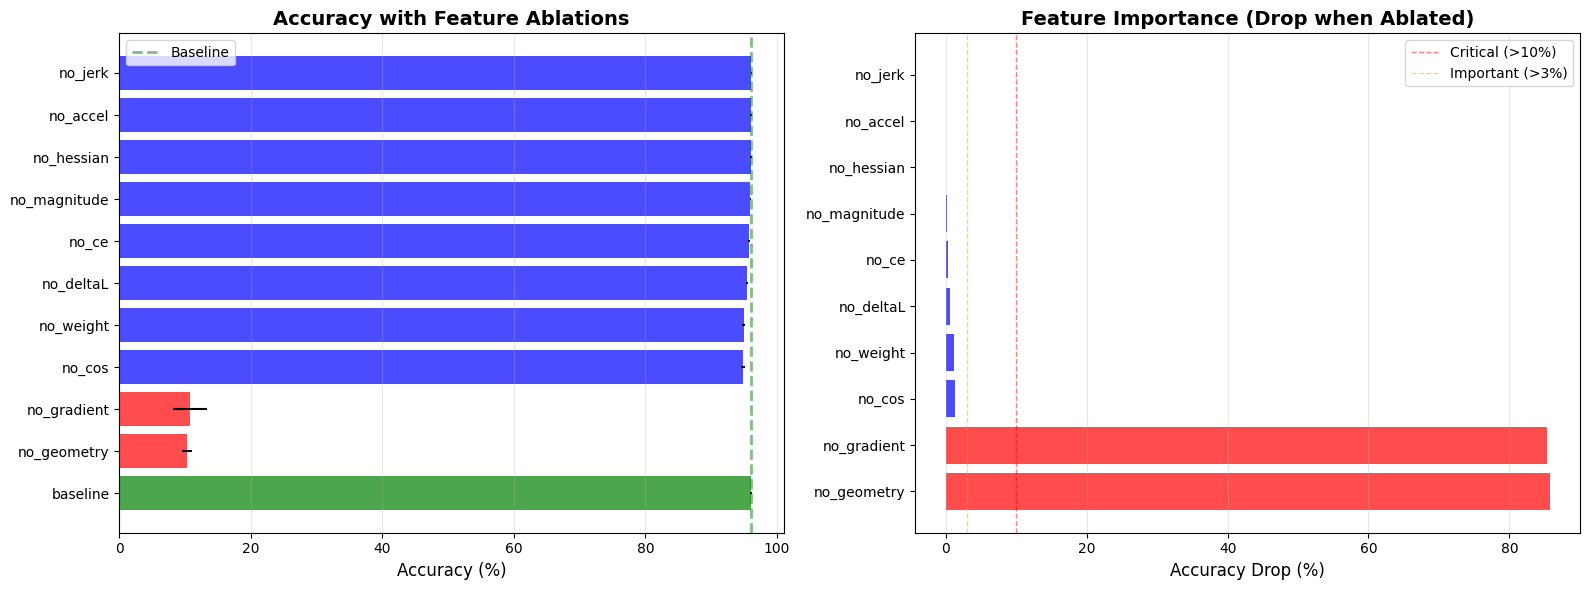


✅ Ablation tests complete!

📋 SUMMARY:
----------------------------------------------------------------------------------------------------
Random features test: +85.8% difference
  → Hypertuner STRONGLY depends on gradient features

Most important features:
  1. no_geometry: -85.7% when removed
  2. no_gradient: -85.3% when removed
  3. no_cos: -1.3% when removed
  4. no_weight: -1.2% when removed
  5. no_deltaL: -0.6% when removed


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from google.colab import drive
import matplotlib.pyplot as plt

# ============================================================
# COMPREHENSIVE FEATURE ABLATION TEST
#
# Tests which features the hypertuner actually uses:
# 1. Random features - does it ignore inputs entirely?
# 2. Individual ablations - which features matter?
# 3. Weight ablation - does it need current weights?
# ============================================================

torch.set_grad_enabled(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Running on {device}")
drive.mount('/content/drive', force_remount=True)

# -----------------------------
# CONFIG
# -----------------------------
experiment_dir = '/content/drive/My Drive/GradientShortCircuit_Experiments'
CHECKPOINT_TO_TEST = 'GSC_Gold_OneStep.pth'
USE_EMA_WEIGHTS = True

NUM_TRIALS = 20
SUPPORT_BATCH = 1024
PROBE_LR = 0.02

# Features
ALPHA_HEAD_MAX = 0.5
APPLY_MAX = 1.5
W0, B0, W1, B1 = 1.8, 1.6, 2.0, 2.2
DELTAL_SCALE = 2.0
DELTAL2_SCALE = 5.0
JERK_EVAL_SCALE = 1e-4

def mult_for_param(i: int) -> float:
    return [W0, B0, W1, B1][i]

# -----------------------------
# DATA
# -----------------------------
class FastMNISTLoader:
    def __init__(self, device):
        print(f"📥 Pre-loading MNIST to GPU VRAM...")
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
        test_data  = datasets.MNIST('./data', train=False, download=True, transform=transform)

        self.device = device
        self.train_x = train_data.data.view(-1, 784).float().to(device) / 255.0
        self.train_y = train_data.targets.to(device)
        self.test_x  = test_data.data.view(-1, 784).float().to(device) / 255.0
        self.test_y  = test_data.targets.to(device)

        self.train_x = (self.train_x - 0.1307) / 0.3081
        self.test_x  = (self.test_x  - 0.1307) / 0.3081
        self.num_train = self.train_x.shape[0]

    def sample_train(self, batch_size):
        idx = torch.randint(0, self.num_train, (batch_size,), device=self.device)
        return self.train_x[idx], self.train_y[idx]

    def get_full_test(self):
        return self.test_x, self.test_y

# -----------------------------
# STUDENT
# -----------------------------
class MNISTStudent(nn.Module):
    def __init__(self, hidden_size=96):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10)
        )

    def forward(self, x):
        return self.net(x)

    def functional_forward(self, x, params):
        x = F.linear(x, params[0], params[1])
        x = F.relu(x)
        x = F.linear(x, params[2], params[3])
        return x

def reset_student(net):
    for m in net.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

# -----------------------------
# FEATURES
# -----------------------------
def soft_squash(x, eps=1e-8):
    s = x.detach().abs().median().clamp(min=eps)
    return torch.tanh(x / (3.0 * s))

def signed_log1p(x):
    return torch.sign(x) * torch.log1p(x.abs())

def compute_probe_and_curv(student, params, x_support, y_support, probe_lr=0.02, jerk_scale=1.0):
    p0 = [p.detach().clone().requires_grad_(True) for p in params]
    logits1 = student.functional_forward(x_support, p0)
    loss1 = F.cross_entropy(logits1, y_support)
    grads1 = torch.autograd.grad(loss1, p0, create_graph=False)
    g1 = [g.detach() for g in grads1]
    h_diag = [g.pow(2) for g in g1]

    p1 = [(pp - probe_lr * gg).detach().requires_grad_(True) for pp, gg in zip(p0, g1)]
    logits2 = student.functional_forward(x_support, p1)
    loss2 = F.cross_entropy(logits2, y_support)
    deltaL1 = float((loss2 - loss1).detach().item())
    grads2 = torch.autograd.grad(loss2, p1, create_graph=False)
    g2 = [g.detach() for g in grads2]
    accel = [g2i - g1i for g1i, g2i in zip(g1, g2)]

    eps = 1e-12
    dot = torch.zeros((), device=g1[0].device)
    n1  = torch.zeros((), device=g1[0].device)
    n2  = torch.zeros((), device=g1[0].device)
    for a, b in zip(g1, g2):
        aa = a.reshape(-1)
        bb = b.reshape(-1)
        dot = dot + (aa * bb).sum()
        n1  = n1  + (aa * aa).sum()
        n2  = n2  + (bb * bb).sum()
    cosv = float((dot / (torch.sqrt(n1).clamp_min(eps) * torch.sqrt(n2).clamp_min(eps))).detach().item())

    p2 = [(pp - probe_lr * gg).detach().requires_grad_(True) for pp, gg in zip(p1, g2)]
    logits3 = student.functional_forward(x_support, p2)
    loss3 = F.cross_entropy(logits3, y_support)
    deltaL2_raw = float((loss3 - loss2).detach().item())
    grads3 = torch.autograd.grad(loss3, p2, create_graph=False)
    g3 = [g.detach() for g in grads3]
    jerk = [jerk_scale * (g3i - 2.0*g2i + g1i) for g1i, g2i, g3i in zip(g1, g2, g3)]

    return g1, accel, jerk, h_diag, deltaL1, deltaL2_raw, cosv

# -----------------------------
# HYPERTUNER
# -----------------------------
class FineGrainedHypertuner37(nn.Module):
    def __init__(self, num_layers=2):
        super().__init__()
        self.layer_embeddings = nn.Embedding(num_layers, 10)
        self.predictor = nn.Sequential(
            nn.Linear(37, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.alpha_head = nn.Sequential(
            nn.Linear(37, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, weight, grad_g1, grad_accel, grad_jerk, h_diag, layer_idx,
                support_ce_scalar, deltaL1_scalar, deltaL2_scalar, cos_scalar,
                ablate_feature=None):
        """
        ablate_feature: str or None
            If specified, zero out that feature group before processing
            Options: 'weight', 'gradient', 'accel', 'jerk', 'hessian',
                     'deltaL', 'cos', 'ce', 'magnitude', 'geometry', 'all'
        """
        batch_size = weight.numel()
        w_flat = weight.reshape(-1, 1)
        g_flat = soft_squash(grad_g1).reshape(-1, 1)
        a_flat = soft_squash(grad_accel).reshape(-1, 1)
        j_flat = soft_squash(grad_jerk).reshape(-1, 1)
        h_feat = soft_squash(signed_log1p(h_diag)).reshape(-1, 1)

        dL1_feat = torch.tanh(torch.full((batch_size, 1), float(deltaL1_scalar) * DELTAL_SCALE,
                                        device=weight.device, dtype=w_flat.dtype))
        dL2_feat = torch.tanh(torch.full((batch_size, 1), float(deltaL2_scalar) * DELTAL2_SCALE,
                                        device=weight.device, dtype=w_flat.dtype))
        cos_feat = torch.full((batch_size, 1), float(cos_scalar), device=weight.device, dtype=w_flat.dtype)
        ce_feat  = torch.full((batch_size, 1), float(support_ce_scalar), device=weight.device, dtype=w_flat.dtype)

        log_mag_g1    = float(torch.log1p(grad_g1.detach().abs().median()).item())
        log_mag_accel = float(torch.log1p(grad_accel.detach().abs().median()).item())
        log_mag_jerk  = float(torch.log1p(grad_jerk.detach().abs().median()).item())
        log_mag_h     = float(torch.log1p(h_diag.detach().abs().median()).item())
        mag_features = torch.tensor([log_mag_g1, log_mag_accel, log_mag_jerk, log_mag_h],
                                    device=weight.device, dtype=w_flat.dtype).unsqueeze(0).expand(batch_size, -1)

        current_center = float(weight.mean().item())
        dist_current_center = torch.log1p((w_flat - current_center).abs())
        center_drift = torch.log1p(torch.abs(torch.tensor(current_center, device=weight.device)))
        center_drift_feat = torch.full((batch_size, 1), float(center_drift.item()),
                                      device=weight.device, dtype=w_flat.dtype)
        grad_mag_raw = torch.log1p(grad_g1.abs()).reshape(-1, 1)
        h_to_g_ratio = soft_squash(h_diag.abs() / (grad_g1.abs() + 1e-8)).reshape(-1, 1)

        if weight.dim() > 1:
            rows, cols = weight.shape
            r_idx = torch.arange(rows, device=weight.device)
            c_idx = torch.arange(cols, device=weight.device)
            r = r_idx.repeat_interleave(cols).float().reshape(-1, 1) / rows
            c = c_idx.repeat(rows).float().reshape(-1, 1) / cols

            center_row, center_col = (rows - 1) / 2.0, (cols - 1) / 2.0
            rr = r_idx.repeat_interleave(cols).float()
            cc = c_idx.repeat(rows).float()
            dist = torch.sqrt((rr - center_row) ** 2 + (cc - center_col) ** 2)
            max_dist = torch.sqrt(torch.tensor(center_row**2 + center_col**2,
                                               device=weight.device, dtype=dist.dtype)).clamp(min=1e-8)
            dist_center = (dist / max_dist).reshape(-1, 1)

            fan_in = max(int(cols), 1)
            sigma = torch.sqrt(torch.tensor(2.0 / fan_in, device=weight.device, dtype=w_flat.dtype)).clamp(min=1e-8)
            dist_origin = torch.log1p(w_flat.abs() / sigma)

            row_norms = grad_g1.norm(dim=1, keepdim=True)
            col_norms = grad_g1.norm(dim=0, keepdim=True).t()
            row_feat = soft_squash(row_norms.repeat_interleave(cols, dim=0))
            col_feat = soft_squash(col_norms.repeat(rows, 1))

            g_mean = g_flat.mean().expand(batch_size, 1)
            g_std  = g_flat.std().expand(batch_size, 1)

            t_in  = torch.full((batch_size, 1), float(np.log1p(cols)), device=weight.device, dtype=w_flat.dtype)
            t_out = torch.full((batch_size, 1), float(np.log1p(rows)), device=weight.device, dtype=w_flat.dtype)
        else:
            rows = weight.shape[0]
            r_idx = torch.arange(rows, device=weight.device)
            r = r_idx.float().reshape(-1, 1) / rows
            c = torch.zeros_like(r)

            center = (rows - 1) / 2.0
            dist = (r_idx.float() - center).abs()
            max_dist = torch.tensor(center, device=weight.device, dtype=dist.dtype).clamp(min=1e-8)
            dist_center = (dist / max_dist).reshape(-1, 1)

            fan_in = 784 if layer_idx == 0 else 96
            sigma = torch.sqrt(torch.tensor(2.0 / fan_in, device=weight.device, dtype=w_flat.dtype)).clamp(min=1e-8)
            dist_origin = torch.log1p(w_flat.abs() / sigma)

            row_feat = soft_squash(grad_g1.abs().reshape(-1, 1))
            col_feat = torch.zeros_like(row_feat)

            g_mean = g_flat.mean().expand(batch_size, 1)
            g_std  = g_flat.std().expand(batch_size, 1)

            t_in  = torch.zeros((batch_size, 1), device=weight.device, dtype=w_flat.dtype)
            t_out = torch.full((batch_size, 1), float(np.log1p(rows)), device=weight.device, dtype=w_flat.dtype)

        l_emb = self.layer_embeddings(torch.tensor([layer_idx], device=weight.device)).expand(batch_size, -1)

        # Apply ablation if specified
        if ablate_feature == 'weight':
            w_flat = torch.zeros_like(w_flat)
            dist_current_center = torch.zeros_like(dist_current_center)
            center_drift_feat = torch.zeros_like(center_drift_feat)
            dist_origin = torch.zeros_like(dist_origin)
        elif ablate_feature == 'gradient':
            g_flat = torch.zeros_like(g_flat)
            g_mean = torch.zeros_like(g_mean)
            g_std = torch.zeros_like(g_std)
            row_feat = torch.zeros_like(row_feat)
            col_feat = torch.zeros_like(col_feat)
            grad_mag_raw = torch.zeros_like(grad_mag_raw)
        elif ablate_feature == 'accel':
            a_flat = torch.zeros_like(a_flat)
        elif ablate_feature == 'jerk':
            j_flat = torch.zeros_like(j_flat)
        elif ablate_feature == 'hessian':
            h_feat = torch.zeros_like(h_feat)
            h_to_g_ratio = torch.zeros_like(h_to_g_ratio)
        elif ablate_feature == 'deltaL':
            dL1_feat = torch.zeros_like(dL1_feat)
            dL2_feat = torch.zeros_like(dL2_feat)
        elif ablate_feature == 'cos':
            cos_feat = torch.zeros_like(cos_feat)
        elif ablate_feature == 'ce':
            ce_feat = torch.zeros_like(ce_feat)
        elif ablate_feature == 'magnitude':
            mag_features = torch.zeros_like(mag_features)
        elif ablate_feature == 'geometry':
            r = torch.zeros_like(r)
            c = torch.zeros_like(c)
            dist_center = torch.zeros_like(dist_center)
            t_in = torch.zeros_like(t_in)
            t_out = torch.zeros_like(t_out)

        inputs = torch.cat([
            w_flat, g_flat, a_flat, j_flat, l_emb, g_mean, g_std, t_in, t_out, r, c,
            dist_center, dist_origin, row_feat, col_feat, h_feat, dL1_feat, dL2_feat,
            cos_feat, ce_feat, mag_features, dist_current_center, center_drift_feat,
            grad_mag_raw, h_to_g_ratio,
        ], dim=1)

        delta = 0.5 * torch.tanh(self.predictor(inputs))
        p_full = (w_flat + delta).view_as(weight)

        a0 = ALPHA_HEAD_MAX * torch.sigmoid(self.alpha_head(inputs))
        return p_full, a0.view_as(weight)

# -----------------------------
# HELPERS
# -----------------------------
@torch.no_grad()
def acc_on_full_test(student, params, x_test, y_test):
    return (student.functional_forward(x_test, params).argmax(1) == y_test).float().mean().item()

@torch.no_grad()
def support_ce(student, x_s, y_s, params):
    return float(F.cross_entropy(student.functional_forward(x_s, params), y_s).item())

def apply_step(params_in, p_full_list, a_list, mult_scale=1.0):
    out = []
    for i, (p, pf, a) in enumerate(zip(params_in, p_full_list, a_list)):
        au = torch.clamp(a * mult_for_param(i) * mult_scale, 0.0, APPLY_MAX)
        out.append(p + au * (pf - p))
    return out

def step_once(ht, student, params_in, x_s, y_s, ablate_feature=None):
    """Apply hypertuner with optional feature ablation"""
    ce = support_ce(student, x_s, y_s, params_in)

    with torch.enable_grad():
        g1, accel, jerk, h0, dL1, dL2, cosv = compute_probe_and_curv(
            student, params_in, x_s, y_s,
            probe_lr=PROBE_LR,
            jerk_scale=JERK_EVAL_SCALE
        )

    p_full, a_list = [], []
    for i, (p, g1i, ai, ji, hi) in enumerate(zip(params_in, g1, accel, jerk, h0)):
        pf, a = ht(p, g1i, ai, ji, hi, i // 2, ce, dL1, dL2, cosv,
                  ablate_feature=ablate_feature)
        p_full.append(pf)
        a_list.append(a)

    out = apply_step(params_in, p_full, a_list, mult_scale=1.0)
    return out

# -----------------------------
# LOAD HYPERTUNER
# -----------------------------
def load_hypertuner(ckpt_path, use_ema=True):
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    if isinstance(ckpt, dict):
        if use_ema and ("ema_state" in ckpt) and (ckpt["ema_state"] is not None):
            state = ckpt["ema_state"]
        elif "model_state" in ckpt:
            state = ckpt["model_state"]
        else:
            state = ckpt
    else:
        state = ckpt

    ht = FineGrainedHypertuner37(num_layers=2).to(device)
    ht.load_state_dict(state, strict=False)
    ht.eval()
    return ht

# -----------------------------
# TESTS
# -----------------------------
def test_random_features(ht, student, fast_loader, trials=20):
    """Test: Real features vs completely random features"""
    print("="*100)
    print("🔬 TEST 1: Real Features vs Random Features")
    print("="*100)
    print("Tests if hypertuner uses gradient/feature inputs or ignores them entirely")
    print("-" * 100)

    x_test, y_test = fast_loader.get_full_test()

    real_accs = []
    random_accs = []

    for trial in range(trials):
        reset_student(student)
        student.eval()
        params0 = [p.detach().clone() for p in student.parameters()]
        x_s, y_s = fast_loader.sample_train(SUPPORT_BATCH)

        # Real features
        with torch.no_grad():
            params_real = step_once(ht, student, params0, x_s, y_s, ablate_feature=None)
        acc_real = acc_on_full_test(student, params_real, x_test, y_test)

        # Random features - replace ALL gradient-based features with noise
        with torch.enable_grad():
            g1, accel, jerk, h0, dL1, dL2, cosv = compute_probe_and_curv(
                student, params0, x_s, y_s, probe_lr=PROBE_LR, jerk_scale=JERK_EVAL_SCALE
            )

        # Randomize all gradient features
        g1_rand = [torch.randn_like(g) for g in g1]
        accel_rand = [torch.randn_like(a) for a in accel]
        jerk_rand = [torch.randn_like(j) for j in jerk]
        h0_rand = [torch.randn_like(h) for h in h0]
        dL1_rand = np.random.randn()
        dL2_rand = np.random.randn()
        cos_rand = np.random.randn()
        ce_rand = np.random.randn()

        p_full_rand, a_list_rand = [], []
        for i, (p, g1i, ai, ji, hi) in enumerate(zip(params0, g1_rand, accel_rand, jerk_rand, h0_rand)):
            pf, a = ht(p, g1i, ai, ji, hi, i // 2, ce_rand, dL1_rand, dL2_rand, cos_rand)
            p_full_rand.append(pf)
            a_list_rand.append(a)

        params_rand = apply_step(params0, p_full_rand, a_list_rand, mult_scale=1.0)
        acc_rand = acc_on_full_test(student, params_rand, x_test, y_test)

        real_accs.append(acc_real)
        random_accs.append(acc_rand)

        print(f"Trial {trial+1:2d} | Real: {acc_real*100:6.2f}% | Random: {acc_rand*100:6.2f}% | "
              f"Diff: {(acc_real-acc_rand)*100:+6.2f}%")

    print("-" * 100)
    mean_diff = (np.mean(real_accs) - np.mean(random_accs)) * 100
    print(f"AVERAGE   | Real: {np.mean(real_accs)*100:6.2f}% | Random: {np.mean(random_accs)*100:6.2f}% | "
          f"Diff: {mean_diff:+6.2f}%")

    print("\n" + "="*100)
    if abs(mean_diff) < 5.0:
        print("⚠️  WARNING: Real ≈ Random! Hypertuner might IGNORE gradient features!")
    elif mean_diff > 50.0:
        print("✅ STRONG EVIDENCE: Hypertuner USES gradient features! (Real >> Random)")
    else:
        print("✅ Hypertuner uses gradient features, but effect is moderate")
    print("="*100 + "\n")

    return {'real': np.mean(real_accs), 'random': np.mean(random_accs), 'diff': mean_diff}

def test_individual_ablations(ht, student, fast_loader, trials=10):
    """Test: Ablate each feature group individually"""
    print("="*100)
    print("🔬 TEST 2: Individual Feature Ablations")
    print("="*100)
    print("Tests which feature groups are most important by zeroing each out")
    print("-" * 100)

    x_test, y_test = fast_loader.get_full_test()

    feature_groups = [
        ('baseline', None),
        ('no_weight', 'weight'),
        ('no_gradient', 'gradient'),
        ('no_accel', 'accel'),
        ('no_jerk', 'jerk'),
        ('no_hessian', 'hessian'),
        ('no_deltaL', 'deltaL'),
        ('no_cos', 'cos'),
        ('no_ce', 'ce'),
        ('no_magnitude', 'magnitude'),
        ('no_geometry', 'geometry'),
    ]

    results = {}

    for name, ablate in feature_groups:
        accs = []
        for trial in range(trials):
            reset_student(student)
            student.eval()
            params0 = [p.detach().clone() for p in student.parameters()]
            x_s, y_s = fast_loader.sample_train(SUPPORT_BATCH)

            with torch.no_grad():
                params = step_once(ht, student, params0, x_s, y_s, ablate_feature=ablate)
            acc = acc_on_full_test(student, params, x_test, y_test)
            accs.append(acc)

        mean_acc = np.mean(accs)
        std_acc = np.std(accs)
        results[name] = {'mean': mean_acc, 'std': std_acc}

        if name == 'baseline':
            print(f"{'Baseline (all features)':<25} | {mean_acc*100:6.2f}% ± {std_acc*100:4.2f}% | [reference]")
        else:
            diff = (results['baseline']['mean'] - mean_acc) * 100
            print(f"{name:<25} | {mean_acc*100:6.2f}% ± {std_acc*100:4.2f}% | Drop: {diff:+6.2f}%")

    print("-" * 100)

    # Rank by importance
    baseline_acc = results['baseline']['mean']
    importance = []
    for name, ablate in feature_groups[1:]:  # Skip baseline
        drop = (baseline_acc - results[name]['mean']) * 100
        importance.append((name, drop))

    importance.sort(key=lambda x: x[1], reverse=True)

    print("\n📊 Feature Importance Ranking (by accuracy drop when ablated):")
    print("-" * 100)
    for i, (name, drop) in enumerate(importance, 1):
        if drop > 10.0:
            status = "⭐ CRITICAL"
        elif drop > 3.0:
            status = "✅ Important"
        elif drop > 1.0:
            status = "⚠️  Moderate"
        else:
            status = "❓ Minimal"
        print(f"{i:2d}. {name:<25} | Drop: {drop:+6.2f}% | {status}")

    print("="*100 + "\n")

    return results, importance

def plot_ablation_results(results, importance):
    """Plot the ablation results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Accuracy with each ablation
    names = [name for name, _ in [('baseline', None)] + importance]
    means = [results[name]['mean'] * 100 for name in names]
    stds = [results[name]['std'] * 100 for name in names]

    colors = ['green'] + ['red' if drop > 10 else 'orange' if drop > 3 else 'blue'
                          for _, drop in importance]

    bars = ax1.barh(range(len(names)), means, xerr=stds, color=colors, alpha=0.7)
    ax1.set_yticks(range(len(names)))
    ax1.set_yticklabels(names)
    ax1.set_xlabel('Accuracy (%)', fontsize=12)
    ax1.set_title('Accuracy with Feature Ablations', fontsize=14, fontweight='bold')
    ax1.axvline(x=means[0], color='green', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')

    # Plot 2: Drop from baseline
    drops = [drop for _, drop in importance]
    names_sorted = [name for name, _ in importance]

    colors2 = ['red' if d > 10 else 'orange' if d > 3 else 'blue' for d in drops]

    ax2.barh(range(len(drops)), drops, color=colors2, alpha=0.7)
    ax2.set_yticks(range(len(drops)))
    ax2.set_yticklabels(names_sorted)
    ax2.set_xlabel('Accuracy Drop (%)', fontsize=12)
    ax2.set_title('Feature Importance (Drop when Ablated)', fontsize=14, fontweight='bold')
    ax2.axvline(x=10, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Critical (>10%)')
    ax2.axvline(x=3, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Important (>3%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

# -----------------------------
# MAIN
# -----------------------------
def main():
    print("\n" + "="*100)
    print("🧪 COMPREHENSIVE FEATURE ABLATION TEST")
    print("="*100)
    print("Testing which features the hypertuner actually uses")
    print("="*100 + "\n")

    # Load data
    fast_loader = FastMNISTLoader(device)
    x_test, y_test = fast_loader.get_full_test()

    # Load hypertuner
    ckpt_path = os.path.join(experiment_dir, 'gold_checkpoints', CHECKPOINT_TO_TEST)
    ht = load_hypertuner(ckpt_path, use_ema=USE_EMA_WEIGHTS)
    print(f"✅ Loaded hypertuner: {CHECKPOINT_TO_TEST}\n")

    # Create student
    student = MNISTStudent(hidden_size=96).to(device)

    # Run tests
    print("\n")
    random_results = test_random_features(ht, student, fast_loader, trials=NUM_TRIALS)

    print("\n")
    ablation_results, importance = test_individual_ablations(ht, student, fast_loader, trials=10)

    print("\n")
    plot_ablation_results(ablation_results, importance)

    print("\n" + "="*100)
    print("✅ Ablation tests complete!")
    print("="*100)

    # Summary
    print("\n📋 SUMMARY:")
    print("-" * 100)
    print(f"Random features test: {random_results['diff']:+.1f}% difference")
    if random_results['diff'] > 50:
        print("  → Hypertuner STRONGLY depends on gradient features")
    elif random_results['diff'] > 10:
        print("  → Hypertuner uses gradient features")
    else:
        print("  → WARNING: Hypertuner may be memorizing!")

    print("\nMost important features:")
    for i, (name, drop) in enumerate(importance[:5], 1):
        print(f"  {i}. {name}: -{drop:.1f}% when removed")

    print("="*100)

if __name__ == "__main__":
    main()